## TODO (before medRxiv)

1. see ADH list

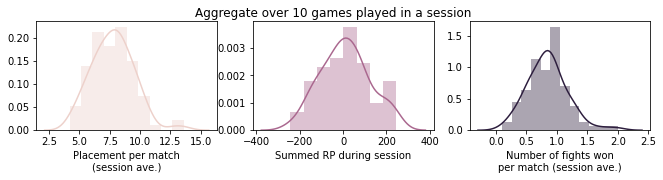

In [133]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def play_game(place, num_fights):
    start = place
    p_fight =  1/(place-1) 
    if np.random.rand(1)>p_fight:
        place = place - 1 
    else: 
        if np.random.rand(1)<np.random.normal(loc=0.5, scale=0.25):
            num_fights = num_fights + 1
            place = place - 1
    if start == place or place==1:
        return place, num_fights
    else:
        return play_game(place, num_fights)
                                
def rp(place, num_fights, ranked_level='plat'):
    # assume even split between squad
    cost = {'bronze':0, 'silver':12, 
            'gold':24, 'plat':36, 
            'diamond':48, 'master':60, 
            'pred':60}
    cost = cost[ranked_level]
    ranked_s7 = {i:(0, 10) for i in range(1, 21)}
    ranked_s7[1] = (100, 25)
    ranked_s7[2] = (60, 20)
    ranked_s7[3] = (40, 20)
    ranked_s7[4] = (40, 15)
    ranked_s7[5] = (30, 15)
    ranked_s7[6] = (30, 12)
    ranked_s7[7] = (20, 12)
    ranked_s7[8] = (20, 12)
    ranked_s7[9] = (10, 12)
    ranked_s7[10] = (10, 12)
    points = ranked_s7[place][0] + ranked_s7[place][1]*num_fights*(1/3) - cost
    return place, num_fights, points
        
def sim(n_games=10, n_sample=100, n_polulation=10000, savefigs=False):
    # population
    data_population = pd.DataFrame()
    for i in range(n_polulation):
        place, num_fights, points = rp(*play_game(20, 0), ranked_level='plat')
        dt = pd.DataFrame({'Place':place, 
                           'n_fights':num_fights,
                           'RP':points}, index=[0])
        data_population = data_population.append(dt, ignore_index=True)
        
    # randomly sample
    if n_sample==None:
        results = data_population
        n_games=1
    else:
        results = pd.DataFrame()
        for i in range(n_sample):
            dt = data_population.sample(n=n_games, replace=True)
            results = results.append(pd.DataFrame({'Place':dt['Place'].mean(), 
                                                   'n_fights':dt['n_fights'].mean(),
                                                   'RP':dt['RP'].sum()}, index=[0]))
    
    # plot
    fig, ax = plt.subplots(1,3, figsize=(11,2))
    sns.distplot(results['Place'], ax=ax[0], color=sns.cubehelix_palette(3)[0])
    sns.distplot(results['RP'], ax=ax[1], color=sns.cubehelix_palette(3)[1])
    sns.distplot(results['n_fights'], ax=ax[2], color=sns.cubehelix_palette(3)[2])
    ax[0].set_xlabel('Placement per match\n(session ave.)')
    ax[1].set_xlabel('Summed RP during session')
    ax[2].set_xlabel('Number of fights won\nper match (session ave.)')
    fig.suptitle('Aggregate over {} games played in a session'.format(n_games))
    
    if savefigs:
        fig.savefig('default_sim.pdf')
        results.to_csv('default_sim.csv')
        
    return results    

results = sim()

Default:
  <RP per session>:14.22	<n_fights won per match>:0.87	<place per match>:7.75
Diff. in means (default - top k=2): -71.73 (P=0.000)
  <RP per session>:85.95	<n_fights won per match>:0.21	<place per match>:6.29
Diff. in means (default - top k=3): -57.55 (P=0.002)
  <RP per session>:71.77	<n_fights won per match>:0.30	<place per match>:6.24
Diff. in means (default - top k=4): -81.05 (P=0.000)
  <RP per session>:95.27	<n_fights won per match>:0.39	<place per match>:5.85
Diff. in means (default - top k=5): -59.95 (P=0.000)
  <RP per session>:74.17	<n_fights won per match>:0.44	<place per match>:6.00
Diff. in means (default - top k=6): -66.68 (P=0.000)
  <RP per session>:80.90	<n_fights won per match>:0.51	<place per match>:6.37
Diff. in means (default - top k=7): -60.10 (P=0.001)
  <RP per session>:74.31	<n_fights won per match>:0.56	<place per match>:6.24
Diff. in means (default - top k=8): -58.47 (P=0.000)
  <RP per session>:72.69	<n_fights won per match>:0.61	<place per match>:6

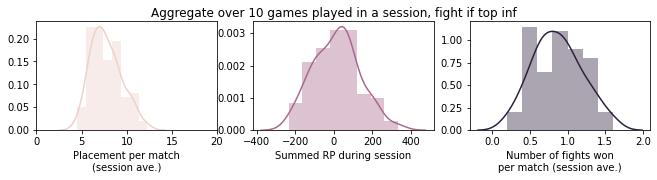

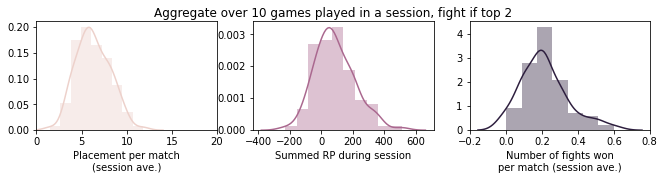

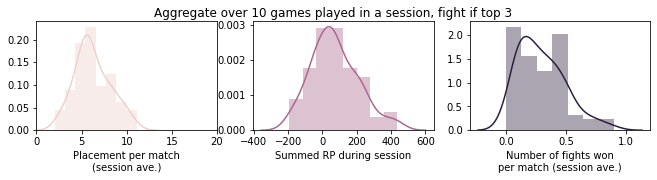

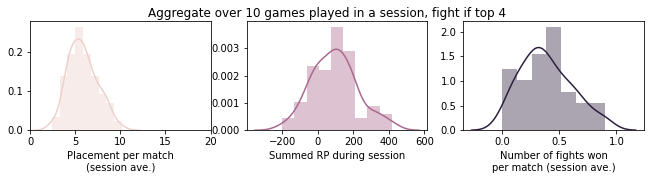

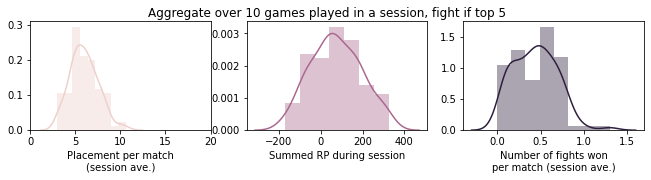

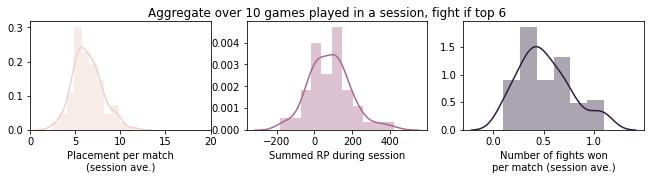

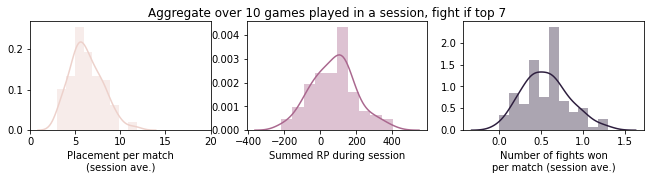

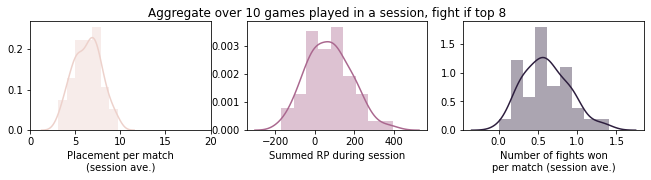

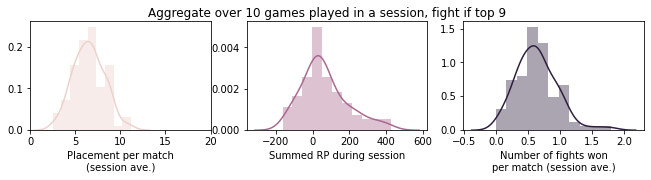

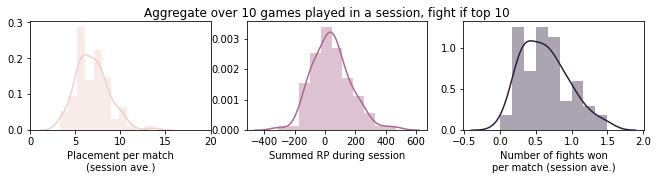

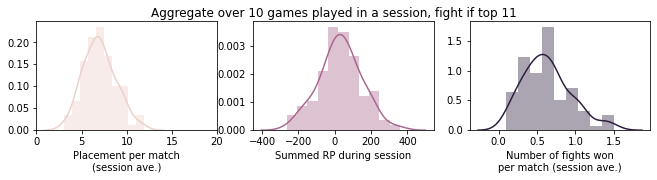

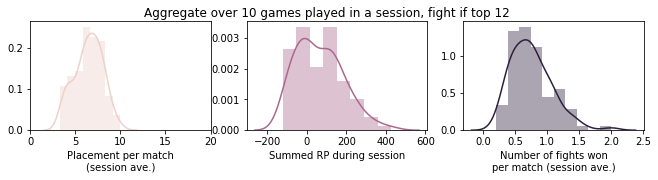

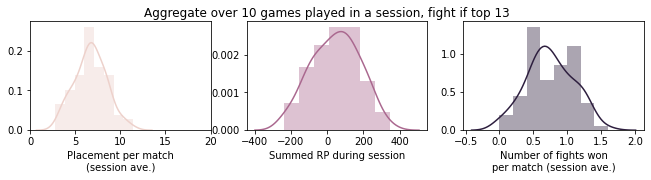

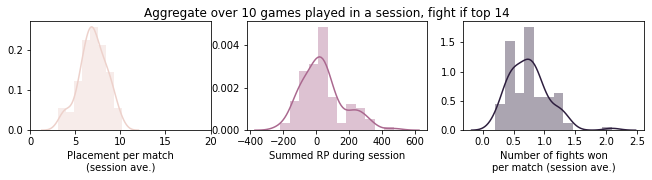

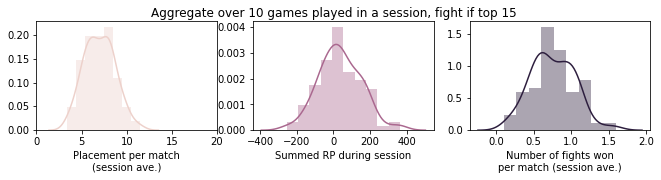

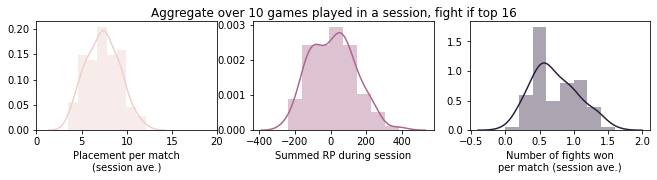

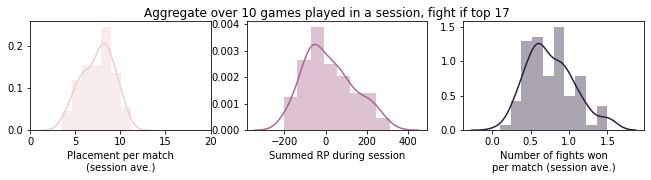

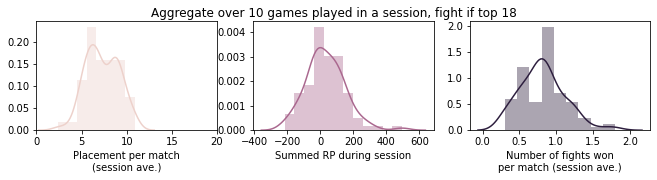

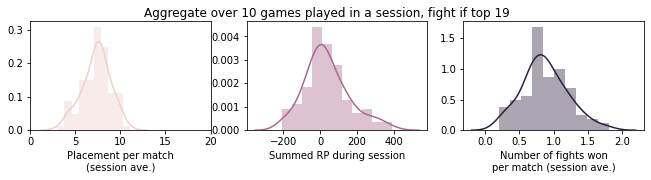

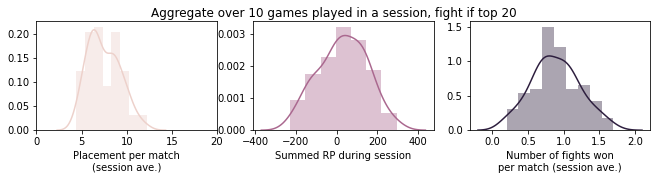

In [172]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def rp(place, num_fights, ranked_level='plat'):
    # assume even split between squad
    cost = {'bronze':0, 'silver':12, 
            'gold':24, 'plat':36, 
            'diamond':48, 'master':60, 
            'pred':60}
    cost = cost[ranked_level]
    ranked_s7 = {i:(0, 10) for i in range(1, 21)}
    ranked_s7[1] = (100, 25)
    ranked_s7[2] = (60, 20)
    ranked_s7[3] = (40, 20)
    ranked_s7[4] = (40, 15)
    ranked_s7[5] = (30, 15)
    ranked_s7[6] = (30, 12)
    ranked_s7[7] = (20, 12)
    ranked_s7[8] = (20, 12)
    ranked_s7[9] = (10, 12)
    ranked_s7[10] = (10, 12)
    points = ranked_s7[place][0] + ranked_s7[place][1]*num_fights*(1/3) - cost
    return place, num_fights, points

def play_game(place, num_fights, topn=np.inf, p_winfight=0.5, p_getaway=0.67):
    '''
    Set topn=np.inf to always fight or topn=2 to be rat
    '''
    start = place
    p_fight =  1/(place-1)
    
    if np.random.rand(1)>p_fight:
        # you didn't have to fight
        place = place - 1
        
    else: 
        if place <= topn: 
            # fight!
            if np.random.rand(1)<np.random.normal(loc=p_winfight, scale=0.25):
                num_fights = num_fights + 1
                place = place - 1
        else:
            # run! 
            if np.random.rand(1) < np.random.normal(loc=p_getaway, scale=0.1):
                place = place - 1
                
    if start == place or place==1:
        return place, num_fights
    else:
        return play_game(place, num_fights, topn=topn)
        
def sim_topn(n_games=10, n_sample=100, n_polulation=10000, topn=np.inf, savefigs=False, ranked_level='plat'):
    # population
    data_population = pd.DataFrame()
    for i in range(n_polulation):
        place, num_fights, points = rp(*play_game(20, 0, topn=topn), ranked_level=ranked_level)
        dt = pd.DataFrame({'Place':place, 
                           'n_fights':num_fights,
                           'RP':points}, index=[0])
        data_population = data_population.append(dt, ignore_index=True)
        
    # randomly sample
    if n_sample==None:
        results = data_population
        n_games=1
    else:
        results = pd.DataFrame()
        for i in range(n_sample):
            dt = data_population.sample(n=n_games, replace=True)
            results = results.append(pd.DataFrame({'Place':dt['Place'].mean(), 
                                                   'n_fights':dt['n_fights'].mean(),
                                                   'RP':dt['RP'].sum()}, index=[0]))
    
    # plot
    fig, ax = plt.subplots(1,3, figsize=(11,2))
    sns.distplot(results['Place'], ax=ax[0], color=sns.cubehelix_palette(3)[0])
    sns.distplot(results['RP'], ax=ax[1], color=sns.cubehelix_palette(3)[1])
    sns.distplot(results['n_fights'], ax=ax[2], color=sns.cubehelix_palette(3)[2])
    ax[0].set_xlim([0,20])
    ax[0].set_xlabel('Placement per match\n(session ave.)')
    ax[1].set_xlabel('Summed RP during session')
    ax[2].set_xlabel('Number of fights won\nper match (session ave.)')
    fig.suptitle('Aggregate over {} games played in a session, fight if top {}'.format(n_games, topn))
    
    if savefigs:
        fig.savefig('default_sim.pdf')
        results.to_csv('default_sim.csv')
        
    return results 

def comparisons():
    default = sim_topn()
    print('Default:')
    print('  <RP per session>:{:.2f}\t<n_fights won per match>:{:.2f}\t<place per match>:{:.2f}'.format(default['RP'].mean(),
                                                                                                 default['n_fights'].mean(),
                                                                                                 default['Place'].mean()))
    for k in range(2, 21):
        results = sim_topn(topn=k)
        print('Diff. in means (default - top k={}): {:.2f} (P={:.3f})'.format(k,
            default['RP'].mean() - results['RP'].mean(),
            ttest_ind(default['RP'], results['RP'], equal_var=False)[1]))
        print('  <RP per session>:{:.2f}\t<n_fights won per match>:{:.2f}\t<place per match>:{:.2f}'.format(results['RP'].mean(), 
                                                                                                     results['n_fights'].mean(),
                                                                                                     results['Place'].mean()))

def experiments(strategy='default'):
    if strategy=='default':
        results = sim_topn()
    elif strategy=='top7':
        results = sim_topn(topn=7)
    elif strategy=='comparisons':
        comparisons()


if False:
    # old debate, just btw fight and hold off till top7
    results_default = experiments()
    results_top7 = experiments(strategy='top7')
elif False:
    diamond = sim_topn(ranked_level='diamond')
elif True:
    experiments(strategy='comparisons')
        


In [44]:
%matplotlib inline

import os
import sys 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import glob
import pickle
import random

!pip install xgboost
import xgboost as xgb
from sklearn.model_selection import GroupShuffleSplit, train_test_split, KFold
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression 
from sklearn.calibration import calibration_curve
from sklearn.impute import SimpleImputer
from sklearn.model_selection import ParameterGrid


!pip install shap
import shap

!pip install hyperopt 
from hyperopt.pyll.stochastic import sample
from timeit import default_timer as timer
from hyperopt import tpe, Trials, fmin, hp, STATUS_OK

from scipy import stats

/usr/bin/sh: 1: pip: not found


ModuleNotFoundError: No module named 'xgboost'

In [ ]:
# pre-processing steps to add to merge_pp()
## TODO: main() into nice py script
dfp = '/home/jovyan/work/ngr4/data/ed_data/final200427/final_4_27'
pdfp = '/home/jovyan/work/ngr4/data/processed/'
pfp = '/home/jovyan/work/ngr4/results/'

# date file for pp'ed IO
filedate = '200430'


if False: 
    # load from full dataset
    print('Loading dataset...')
    df = pd.read_csv(os.path.join(pdfp,'eddata_model_df{}.csv'.format(filedate)))
    
    print(df['merged_outcome'].value_counts(dropna=False))
    
    test_df_cci = df.loc[df['DepartmentName']=='SRC EMERGENCY DEPARTMENT',:]
    train_df_cci = df.loc[df['DepartmentName']!='SRC EMERGENCY DEPARTMENT',:]

    test_df_cci = test_df_cci.drop(columns=['DepartmentName'])
    train_df_cci = train_df_cci.drop(columns=['DepartmentName'])

    X_test_cci = test_df_cci.loc[:,['mrtlt_scr','curb65','qSOFA']]
    X_test = test_df_cci
    X_test = X_test.drop(columns=['visit_occurrence_id','person_id',
                                  'primary_outcome_yn','mrtlt_scr','exclude_yn',
#                                   'o2_exclude',
                                  'merged_outcome','o2_outcome',
#                                     'exclude2_yn', # b/c not in dict
                                  'qSOFA','curb65'])
    y_test = test_df_cci['merged_outcome'] 
    
    X_train_cci = train_df_cci.loc[:,['mrtlt_scr','curb65','qSOFA']]
    X_train = train_df_cci
    X_train = X_train.drop(columns=['visit_occurrence_id','person_id',
                                    'primary_outcome_yn','mrtlt_scr','exclude_yn',
#                                     'o2_exclude',
                                    'merged_outcome','o2_outcome',
#                                     'exclude2_yn', # b/c not in dict
                                    'qSOFA','curb65'])
    y_train = train_df_cci['merged_outcome'] 

    if True:
        X_test.to_csv(os.path.join(pdfp,'X_test.csv'))
        y_test.to_csv(os.path.join(pdfp,'y_test.csv'))
        X_test_cci.to_csv(os.path.join(pdfp,'X_test_cci.csv'))

        X_train.to_csv(os.path.join(pdfp,'X_train.csv'))
        y_train.to_csv(os.path.join(pdfp,'y_train.csv'))
        X_train_cci.to_csv(os.path.join(pdfp,'X_train_cci.csv'))
else:
    X_train = pd.read_csv(os.path.join(pdfp,'X_train.csv'),index_col=0)
    y_train = pd.read_csv(os.path.join(pdfp,'y_train.csv'),index_col=0)
    X_test = pd.read_csv(os.path.join(pdfp,'X_test.csv'),index_col=0)
    y_test = pd.read_csv(os.path.join(pdfp,'y_test.csv'),index_col=0)
    X_train_cci = pd.read_csv(os.path.join(pdfp,'X_train_cci.csv'),index_col=0)


In [ ]:
def qcsi(df):
    """Calcualate quick-CSI and return score for training.
    Arguments:
        df (pd.DataFrame): can be within cv-fold
    """
    # impute
    temp = SimpleImputer(verbose=1, strategy='median').fit_transform(df)
    ## convert back to pandas
    df = pd.DataFrame(temp, columns=df.columns, dtype='float64')
    temp = pd.DataFrame()
    temp['last_o2_flow'] = pd.cut(df['last_o2_flow'],
                                 bins=[-np.inf,2,4,np.inf],
                                 labels=['no_nc','2-4','gt4'])
    temp['min_SPO2'] = pd.cut(df['min_SPO2'],
                                 bins=[-np.inf,88,92,np.inf],
                                 labels=['lt88','88-92','gt92'])
    temp['last_RR'] = pd.cut(df['last_RR'],
                                 bins=[-np.inf,22,28,np.inf],
                                 labels=['lt22','22-28','gt28'])
    # round(2*OR) - 2
    temp['qcsi'] = 0
    temp.loc[temp['last_o2_flow']=='2-4','qcsi'] = 4 + temp.loc[temp['last_o2_flow']=='2-4','qcsi']
    temp.loc[temp['last_o2_flow']=='gt4','qcsi'] = 5 + temp.loc[temp['last_o2_flow']=='gt4','qcsi']
    temp.loc[temp['min_SPO2']=='lt88','qcsi'] = 5 + temp.loc[temp['min_SPO2']=='lt88','qcsi']
    temp.loc[temp['min_SPO2']=='88-92','qcsi'] = 2 + temp.loc[temp['min_SPO2']=='88-92','qcsi']
    temp.loc[temp['last_RR']=='22-28','qcsi'] = 1 + temp.loc[temp['last_RR']=='22-28','qcsi']
    temp.loc[temp['last_RR']=='gt28','qcsi'] = 2 + temp.loc[temp['last_RR']=='gt28','qcsi']
    
    return temp['qcsi'] 

def proper_curb65(df):
    """CURB-65 with consistency for qcsi.
    
    Now corrected for GCS < 15
    
    Arguments:
        df (pd.DataFrame): can be within cv-fold
        
    Returns:
        pd.Series
    """
    # impute
    temp = SimpleImputer(verbose=1, strategy='median').fit_transform(df)
    
    ## convert back to pandas
    df = pd.DataFrame(temp, columns=df.columns, dtype='float64')
    
    df['curb65'] = (df['last_GCS']<15).astype(int) + (df['bun']>=19).astype(int) + (df['last_RR']>=30).astype(int) + ((df['last_SBP']<90)|(df['last_DBP']<=60)).astype(int) + (df['age']>=65)
    return df['curb65']

def proper_qSOFA(df):
    """Calculate qSOFA score based on worst measurements.
    
    1-pt for each, GCS=<15, RR≥22, sBP<=100.
    
    Returns:
        pd.DataFrame: with value added into col='curb65'
    
    Reference:
        https://www.mdcalc.com/qsofa-quick-sofa-score-sepsis
    """
    # impute
    temp = SimpleImputer(verbose=1, strategy='median').fit_transform(df)
    
    ## convert back to pandas
    df = pd.DataFrame(temp, columns=df.columns, dtype='float64')
    df['qSOFA'] = (df['last_GCS']<15).astype(int) + (df['last_RR']>=22).astype(int) + (df['last_SBP']<=100)
    return df['qSOFA']


    


# qCSI

In [12]:
method = 'LR'
model_name = 'qCSIredo'

# metrics to store
aucs = []
praucs = []
brier = []

mets = pd.DataFrame()
roc = pd.DataFrame()
prc = pd.DataFrame()


ave_n = pd.DataFrame()
odds_ratio = pd.DataFrame()

n_iter = 1000

# pre-filter data
X_train_sub = X_train
X_train_sub.loc[X_train_sub['ox_status240_ROOM_AIR']==1,'last_o2_flow'] = 0 

tic = time.time()
for i in range(n_iter):
    
    kfolds = 10
    kf = KFold(n_splits=kfolds, shuffle=True)
        
    # cross val
    eval_metric = []
    dtn = pd.DataFrame()
    for idx_train, idx_val in kf.split(X_train_sub):
        
        X_train_cv, X_val = X_train_sub.iloc[idx_train,:], X_train_sub.iloc[idx_val,:]
        y_train_cv, y_val = y_train.iloc[idx_train],y_train.iloc[idx_val]
        
        X_train_scaled = qcsi(X_train_cv)
        X_val_scaled = qcsi(X_val)
        
        # run default params
        model = LogisticRegression(max_iter=10000, 
                                   n_jobs=-1)
        model.fit(X_train_scaled.to_numpy().reshape(-1, 1), y_train_cv.values.ravel()) 
        
        p1_cv = model.predict_proba(X_val_scaled.to_numpy().reshape(-1,1))[:,1]
        auroc_cv = metrics.roc_auc_score(y_val.values.ravel(),p1_cv)
        
        eval_metric.append(auroc_cv)
        
        bins = [-np.inf, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, np.inf]
        n_pos,_,_=stats.binned_statistic(X_val_scaled.to_numpy(), y_val.iloc[:,0].to_numpy(), bins=bins, statistic='sum')
        n,_,_=stats.binned_statistic(X_val_scaled.to_numpy(), y_val.iloc[:,0].to_numpy(), bins=bins, statistic='count')
        dtn = dtn.append(dict(zip([str(i) if i not in [-np.inf,np.inf] else 'inf' for i in bins[1:]],n_pos/n)),ignore_index=True)   
#         dtn = dtn.append(dict(zip([str(i) if i not in [-np.inf,np.inf] else 'inf' for i in bins[1:]],n_pos)),ignore_index=True)   
        if auroc_cv >= np.max(eval_metric):
            bst = model
            X_val_eval, y_val_eval = X_val_scaled, y_val
            X_train_eval, y_train_eval = X_train_scaled, y_train_cv
        
    p1 = bst.predict_proba(X_val_eval.to_numpy().reshape(-1,1))[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_val_eval, p1)
    optimal_idx = np.argmax(tpr-fpr)
    optimal_threshold = thresholds[optimal_idx]
    optimal_pred = (p1>optimal_threshold).astype(int)
    precision,recall,_ = metrics.precision_recall_curve(y_val_eval, p1)
    auprc = metrics.auc(recall, precision)
    auroc = metrics.roc_auc_score(y_val_eval,p1)
    ap = metrics.average_precision_score(y_val_eval,p1)
    bs = metrics.brier_score_loss(y_val_eval,p1)
    f1 = metrics.f1_score(y_val_eval,optimal_pred)
    acc = metrics.accuracy_score(y_val_eval,optimal_pred)
    
    if False:
        # multi col
        dt = pd.DataFrame(np.exp(bst.coef_), columns=X_train_scaled.columns)
        odds_ratio = odds_ratio.append(dt, ignore_index=True)
    else:
        odds_ratio = odds_ratio.append({X_train_scaled.name:np.squeeze(np.exp(bst.coef_))}, ignore_index=True)
    
    # store vals
    mets = mets.append(pd.DataFrame({'au-roc':auroc,
                                           'au-prc':auprc,
                                           'brier':bs,
                                           'f1':f1,
                                           'accuracy':acc,
                                           'sensitivity':tpr[optimal_idx],
                                           'specificity':1-fpr[optimal_idx],
                                           'ave_precision':ap},index=[0]),
                            ignore_index=True)

    roc = roc.append(pd.DataFrame({'fpr':fpr,
                                   'tpr':tpr,
                                   'iter':[i]*fpr.shape[0]}),
                     ignore_index=True)
    prc = prc.append(pd.DataFrame({'precision':precision,
                                   'recall':recall,
                                   'iter':[i]*precision.shape[0]}),
                     ignore_index=True)
    
    # TO BE DEPRECATED
    aucs.append(auroc)
    praucs.append(auprc)
    brier.append(bs)
    ave_n = ave_n.append(dtn.mean(axis=0), ignore_index=True)
    
    
    if True:
        # save bst so far, delete others
        if aucs[-1] >= np.max(aucs): 
            # if now best, save
            with open(os.path.join(pdfp, '{}_{}iter{}.pkl'.format(model_name,method,i)),'wb') as f:
                pickle.dump(bst, f, pickle.HIGHEST_PROTOCOL)
            f.close()
            pd.DataFrame(X_train_eval).to_csv(os.path.join(pdfp,'{}_{}iter{}_Xtrain.csv'.format(model_name,method,i)), index=False)
            y_train_eval.to_csv(os.path.join(pdfp,'{}_{}iter{}_ytrain.csv'.format(model_name,method,i)), index=False)
            pd.DataFrame(X_val_eval).to_csv(os.path.join(pdfp,'{}_{}iter{}_Xval.csv'.format(model_name,method,i)), index=False)
            y_val_eval.to_csv(os.path.join(pdfp,'{}_{}iter{}_yval.csv'.format(model_name,method,i)), index=False)
            
            
            # clear others
            for pkl in glob.glob(os.path.join(pdfp,'{}_{}iter*.pkl'.format(model_name,method))): # just keep iter
                if int(os.path.split(pkl)[1].split('.pkl')[0].split('iter')[1]) != i:
                    os.remove(pkl)
            for datacsv in glob.glob(os.path.join(pdfp,'{}_{}iter*_*.csv'.format(model_name,method))): # just keep iter
                if int(os.path.split(datacsv)[1].split('{}_{}iter'.format(model_name,method))[1].split('_')[0]) != i:
                    os.remove(datacsv)     
    
    p_done = 100*(i+1)/n_iter
    n_left = n_iter - (i+1)
    toc = time.time() - tic
    
    if i % 10 == 0:
        print('through {:.2f}-% in {:.1f}-s\t~{:.1f}-min left'.format(p_done,toc,n_left*((toc/60)/(i+1))))
        print('  <auc-roc>:{:.2f} ({:.2f},{:.2f})\t<auc-pr>:{:.2f} ({:.2f},{:.2f})\t<brier>:{:.2f} ({:.2f},{:.2f})\n'.format(
            np.mean(aucs),np.quantile(aucs,0.025),np.quantile(aucs,0.975),
            np.mean(praucs),np.quantile(praucs,0.025),np.quantile(praucs,0.975),
            np.mean(brier),np.quantile(brier,0.025),np.quantile(brier,0.975)))
        
    if i % 100 == 0:
        print('\n{} {} results (n_iter: {})'.format(model_name, method,i))
        print('---------------------------------')
        print('\t<metric>\t(bootstrapped 95% CI)')
        print('AU-ROC\t{:.4f}\t({:.2f}, {:.2f})'.format(np.mean(aucs),np.quantile(aucs,0.025),np.quantile(aucs,0.975)))
        print('AU-PR\t{:.4f}\t({:.2f}, {:.2f})'.format(np.mean(praucs),np.quantile(praucs,0.025),np.quantile(praucs,0.975)))
        print('Brier\t{:.4f}\t({:.2f}, {:.2f})'.format(np.mean(brier),np.quantile(brier,0.025),np.quantile(brier,0.975)))

        print('')

        if True:
            # print odds ratios
            odds_ratio = odds_ratio.astype(float)    
            odds_ratio_table = pd.DataFrame({'Variable':odds_ratio.columns,
                                             'OR':odds_ratio.mean(),
                                             'lower95pCI':odds_ratio.quantile(q=0.025),
                                             'upper95pCI':odds_ratio.quantile(q=0.975)})
            ave_n_table = ave_n.mean(axis=0)
            ave_n_table = ave_n_table.reset_index().astype(float).sort_values('index')
            print('\n{} {} odds ratios'.format(model_name,method))
            print('---------------------------------')
            print('Variable\t<OR>\t(bootstrapped 95% CI)\t<n_val>')
            for var in odds_ratio_table['Variable'].unique():
                print('{}\t{:.2f}\t({:.2f}, {:.2f})'.format(var,
                                                             odds_ratio_table.loc[var,'OR'],
                                                             odds_ratio_table.loc[var,'lower95pCI'],
                                                             odds_ratio_table.loc[var,'upper95pCI']))
            print('\n<n_pos/n>_cv-folds per bin:')
            for i,bin_edge in enumerate(ave_n_table['index'].unique()):
                print('  bin edge: {:.0f}\t{:.2f}'.format(bin_edge,ave_n_table.loc[ave_n_table['index']==bin_edge,0].to_list()[0]))

            print('')
if True:
    # save boostrap
    mets.to_csv(os.path.join(pdfp,'{}_{}optimized_bootstraps.csv'.format(model_name,method)),index=False)
    prc.to_csv(os.path.join(pdfp,'{}_{}prc_bootstraps.csv'.format(model_name,method)),index=False)
    roc.to_csv(os.path.join(pdfp,'{}_{}roc_bootstraps.csv'.format(model_name,method)),index=False)
    
print('\n{} {} results (n_iter: {})'.format(model_name, method,n_iter))
print('---------------------------------')
print('\t<metric>\t(bootstrapped 95% CI)')
print('AU-ROC\t{:.4f}\t({:.2f}, {:.2f})'.format(np.mean(aucs),np.quantile(aucs,0.025),np.quantile(aucs,0.975)))
print('AU-PR\t{:.4f}\t({:.2f}, {:.2f})'.format(np.mean(praucs),np.quantile(praucs,0.025),np.quantile(praucs,0.975)))
print('Brier\t{:.4f}\t({:.2f}, {:.2f})'.format(np.mean(brier),np.quantile(brier,0.025),np.quantile(brier,0.975)))

print('')

if True:
    # print odds ratios
    odds_ratio = odds_ratio.astype(float)    
    odds_ratio_table = pd.DataFrame({'Variable':odds_ratio.columns,
                                     'OR':odds_ratio.mean(),
                                     'lower95pCI':odds_ratio.quantile(q=0.025),
                                     'upper95pCI':odds_ratio.quantile(q=0.975)})
    ave_n_table = ave_n.mean(axis=0)
    ave_n_table = ave_n_table.reset_index().astype(float).sort_values('index')
    print('\n{} {} odds ratios'.format(model_name,method))
    print('---------------------------------')
    print('Variable\t<OR>\t(bootstrapped 95% CI)\t<n_val>')
    for var in odds_ratio_table['Variable'].unique():
        print('{}\t{:.2f}\t({:.2f}, {:.2f})'.format(var,
                                                     odds_ratio_table.loc[var,'OR'],
                                                     odds_ratio_table.loc[var,'lower95pCI'],
                                                     odds_ratio_table.loc[var,'upper95pCI']))
    print('\n<n_pos/n>_cv-folds per bin:')
    for i,bin_edge in enumerate(ave_n_table['index'].unique()):
        print('  bin edge: {:.0f}\t{:.2f}'.format(bin_edge,ave_n_table.loc[ave_n_table['index']==bin_edge,0].to_list()[0]))
    
            
        
        

invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 0.10-% in 4.3-s	~71.6-min left
  <auc-roc>:0.92 (0.92,0.92)	<auc-pr>:0.51 (0.51,0.51)	<brier>:0.05 (0.05,0.05)


qCSIredo LR results (n_iter: 0)
---------------------------------
	<metric>	(bootstrapped 95% CI)
AU-ROC	0.9236	(0.92, 0.92)
AU-PR	0.5114	(0.51, 0.51)
Brier	0.0538	(0.05, 0.05)


qCSIredo LR odds ratios
---------------------------------
Variable	<OR>	(bootstrapped 95% CI)	<n_val>
qcsi	1.38	(1.38, 1.38)

<n_pos/n>_cv-folds per bin:
  bin edge: 1	0.02
  bin edge: 2	0.12
  bin edge: 3	0.09
  bin edge: 4	0.10
  bin edge: 5	0.20
  bin edge: 6	0.24
  bin edge: 7	0.20
  bin edge: 8	0.24
  bin edge: 9	0.32
  bin edge: 10	0.25
  bin edge: 11	0.48
  bin edge: inf	0.79



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 1.10-% in 14.4-s	~21.7-min left
  <auc-roc>:0.90 (0.85,0.94)	<auc-pr>:0.58 (0.41,0.76)	<brier>:0.07 (0.05,0.10)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 2.10-% in 23.6-s	~18.3-min left
  <auc-roc>:0.90 (0.86,0.94)	<auc-pr>:0.56 (0.32,0.74)	<brier>:0.07 (0.05,0.10)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 3.10-% in 32.8-s	~17.1-min left
  <auc-roc>:0.89 (0.85,0.94)	<auc-pr>:0.53 (0.28,0.73)	<brier>:0.07 (0.05,0.10)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 4.10-% in 41.9-s	~16.3-min left
  <auc-roc>:0.89 (0.85,0.94)	<auc-pr>:0.54 (0.29,0.71)	<brier>:0.07 (0.05,0.10)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 5.10-% in 50.9-s	~15.8-min left
  <auc-roc>:0.89 (0.85,0.96)	<auc-pr>:0.53 (0.26,0.76)	<brier>:0.07 (0.04,0.10)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 6.10-% in 60.0-s	~15.4-min left
  <auc-roc>:0.89 (0.85,0.96)	<auc-pr>:0.53 (0.27,0.74)	<brier>:0.07 (0.04,0.10)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 7.10-% in 69.3-s	~15.1-min left
  <auc-roc>:0.89 (0.85,0.96)	<auc-pr>:0.54 (0.28,0.73)	<brier>:0.07 (0.04,0.10)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 8.10-% in 78.3-s	~14.8-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.54 (0.29,0.78)	<brier>:0.07 (0.04,0.10)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 9.10-% in 87.6-s	~14.6-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.54 (0.29,0.77)	<brier>:0.07 (0.04,0.10)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 10.10-% in 96.4-s	~14.3-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.76)	<brier>:0.07 (0.04,0.10)


qCSIredo LR results (n_iter: 100)
---------------------------------
	<metric>	(bootstrapped 95% CI)
AU-ROC	0.8963	(0.85, 0.96)
AU-PR	0.5464	(0.30, 0.76)
Brier	0.0722	(0.04, 0.10)


qCSIredo LR odds ratios
---------------------------------
Variable	<OR>	(bootstrapped 95% CI)	<n_val>
qcsi	1.38	(1.36, 1.40)

<n_pos/n>_cv-folds per bin:
  bin edge: 1	0.02
  bin edge: 2	0.17
  bin edge: 3	0.09
  bin edge: 4	0.09
  bin edge: 5	0.18
  bin edge: 6	0.21
  bin edge: 7	0.23
  bin edge: 8	0.31
  bin edge: 9	0.35
  bin edge: 10	0.27
  bin edge: 11	0.42
  bin edge: inf	0.83



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 11.10-% in 105.7-s	~14.1-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.75)	<brier>:0.07 (0.04,0.10)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 12.10-% in 114.7-s	~13.9-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.10)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 13.10-% in 123.9-s	~13.7-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.10)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 14.10-% in 133.2-s	~13.5-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.76)	<brier>:0.07 (0.04,0.10)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 15.10-% in 142.3-s	~13.3-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.75)	<brier>:0.07 (0.04,0.10)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 16.10-% in 151.6-s	~13.2-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.10)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 17.10-% in 160.7-s	~13.0-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.77)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 18.10-% in 170.0-s	~12.8-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.29,0.76)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 19.10-% in 179.1-s	~12.6-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.75)	<brier>:0.07 (0.04,0.10)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 20.10-% in 188.2-s	~12.5-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.10)


qCSIredo LR results (n_iter: 200)
---------------------------------
	<metric>	(bootstrapped 95% CI)
AU-ROC	0.8965	(0.85, 0.96)
AU-PR	0.5471	(0.30, 0.74)
Brier	0.0725	(0.04, 0.10)


qCSIredo LR odds ratios
---------------------------------
Variable	<OR>	(bootstrapped 95% CI)	<n_val>
qcsi	1.38	(1.36, 1.40)

<n_pos/n>_cv-folds per bin:
  bin edge: 1	0.02
  bin edge: 2	0.17
  bin edge: 3	0.09
  bin edge: 4	0.09
  bin edge: 5	0.19
  bin edge: 6	0.21
  bin edge: 7	0.23
  bin edge: 8	0.31
  bin edge: 9	0.35
  bin edge: 10	0.28
  bin edge: 11	0.42
  bin edge: inf	0.84



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 21.10-% in 197.3-s	~12.3-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 22.10-% in 206.4-s	~12.1-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 23.10-% in 215.8-s	~12.0-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 24.10-% in 225.2-s	~11.8-min left
  <auc-roc>:0.89 (0.85,0.96)	<auc-pr>:0.54 (0.30,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 25.10-% in 234.4-s	~11.7-min left
  <auc-roc>:0.89 (0.84,0.96)	<auc-pr>:0.54 (0.30,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 26.10-% in 243.6-s	~11.5-min left
  <auc-roc>:0.89 (0.85,0.96)	<auc-pr>:0.54 (0.29,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 27.10-% in 252.8-s	~11.3-min left
  <auc-roc>:0.89 (0.84,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 28.10-% in 262.0-s	~11.2-min left
  <auc-roc>:0.89 (0.84,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 29.10-% in 271.2-s	~11.0-min left
  <auc-roc>:0.89 (0.84,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 30.10-% in 280.8-s	~10.9-min left
  <auc-roc>:0.89 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)


qCSIredo LR results (n_iter: 300)
---------------------------------
	<metric>	(bootstrapped 95% CI)
AU-ROC	0.8940	(0.85, 0.96)
AU-PR	0.5485	(0.30, 0.74)
Brier	0.0728	(0.04, 0.11)


qCSIredo LR odds ratios
---------------------------------
Variable	<OR>	(bootstrapped 95% CI)	<n_val>
qcsi	1.38	(1.36, 1.40)

<n_pos/n>_cv-folds per bin:
  bin edge: 1	0.02
  bin edge: 2	0.16
  bin edge: 3	0.09
  bin edge: 4	0.09
  bin edge: 5	0.19
  bin edge: 6	0.21
  bin edge: 7	0.23
  bin edge: 8	0.31
  bin edge: 9	0.35
  bin edge: 10	0.28
  bin edge: 11	0.42
  bin edge: inf	0.83



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 31.10-% in 290.4-s	~10.7-min left
  <auc-roc>:0.89 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 32.10-% in 303.0-s	~10.7-min left
  <auc-roc>:0.89 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 33.10-% in 314.9-s	~10.6-min left
  <auc-roc>:0.89 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 34.10-% in 324.1-s	~10.4-min left
  <auc-roc>:0.89 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 35.10-% in 333.1-s	~10.3-min left
  <auc-roc>:0.89 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 36.10-% in 342.0-s	~10.1-min left
  <auc-roc>:0.89 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 37.10-% in 350.8-s	~9.9-min left
  <auc-roc>:0.89 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 38.10-% in 359.6-s	~9.7-min left
  <auc-roc>:0.89 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 39.10-% in 368.5-s	~9.6-min left
  <auc-roc>:0.89 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 40.10-% in 377.3-s	~9.4-min left
  <auc-roc>:0.89 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)


qCSIredo LR results (n_iter: 400)
---------------------------------
	<metric>	(bootstrapped 95% CI)
AU-ROC	0.8944	(0.85, 0.96)
AU-PR	0.5476	(0.30, 0.74)
Brier	0.0724	(0.04, 0.11)


qCSIredo LR odds ratios
---------------------------------
Variable	<OR>	(bootstrapped 95% CI)	<n_val>
qcsi	1.38	(1.36, 1.40)

<n_pos/n>_cv-folds per bin:
  bin edge: 1	0.02
  bin edge: 2	0.17
  bin edge: 3	0.09
  bin edge: 4	0.09
  bin edge: 5	0.19
  bin edge: 6	0.21
  bin edge: 7	0.23
  bin edge: 8	0.31
  bin edge: 9	0.35
  bin edge: 10	0.28
  bin edge: 11	0.43
  bin edge: inf	0.83



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 41.10-% in 386.2-s	~9.2-min left
  <auc-roc>:0.89 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 42.10-% in 395.5-s	~9.1-min left
  <auc-roc>:0.89 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 43.10-% in 404.9-s	~8.9-min left
  <auc-roc>:0.89 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 44.10-% in 414.0-s	~8.7-min left
  <auc-roc>:0.89 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 45.10-% in 423.4-s	~8.6-min left
  <auc-roc>:0.89 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 46.10-% in 432.7-s	~8.4-min left
  <auc-roc>:0.89 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 47.10-% in 442.4-s	~8.3-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 48.10-% in 451.7-s	~8.1-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 49.10-% in 461.1-s	~8.0-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 50.10-% in 470.4-s	~7.8-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)


qCSIredo LR results (n_iter: 500)
---------------------------------
	<metric>	(bootstrapped 95% CI)
AU-ROC	0.8955	(0.85, 0.96)
AU-PR	0.5488	(0.30, 0.74)
Brier	0.0721	(0.04, 0.11)


qCSIredo LR odds ratios
---------------------------------
Variable	<OR>	(bootstrapped 95% CI)	<n_val>
qcsi	1.38	(1.36, 1.40)

<n_pos/n>_cv-folds per bin:
  bin edge: 1	0.02
  bin edge: 2	0.17
  bin edge: 3	0.09
  bin edge: 4	0.09
  bin edge: 5	0.19
  bin edge: 6	0.21
  bin edge: 7	0.23
  bin edge: 8	0.31
  bin edge: 9	0.35
  bin edge: 10	0.28
  bin edge: 11	0.43
  bin edge: inf	0.83



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 51.10-% in 479.7-s	~7.7-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 52.10-% in 488.9-s	~7.5-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 53.10-% in 499.1-s	~7.3-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.75)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 54.10-% in 508.5-s	~7.2-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.75)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 55.10-% in 518.7-s	~7.0-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.75)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 56.10-% in 528.3-s	~6.9-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.75)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 57.10-% in 537.5-s	~6.7-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.75)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 58.10-% in 546.6-s	~6.6-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.75)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 59.10-% in 555.5-s	~6.4-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 60.10-% in 564.6-s	~6.2-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)


qCSIredo LR results (n_iter: 600)
---------------------------------
	<metric>	(bootstrapped 95% CI)
AU-ROC	0.8959	(0.85, 0.96)
AU-PR	0.5470	(0.30, 0.74)
Brier	0.0717	(0.04, 0.11)


qCSIredo LR odds ratios
---------------------------------
Variable	<OR>	(bootstrapped 95% CI)	<n_val>
qcsi	1.38	(1.36, 1.40)

<n_pos/n>_cv-folds per bin:
  bin edge: 1	0.02
  bin edge: 2	0.17
  bin edge: 3	0.09
  bin edge: 4	0.09
  bin edge: 5	0.19
  bin edge: 6	0.21
  bin edge: 7	0.23
  bin edge: 8	0.31
  bin edge: 9	0.35
  bin edge: 10	0.27
  bin edge: 11	0.43
  bin edge: inf	0.83



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 61.10-% in 573.8-s	~6.1-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 62.10-% in 583.0-s	~5.9-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.75)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 63.10-% in 592.3-s	~5.8-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.74)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 64.10-% in 601.4-s	~5.6-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.75)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 65.10-% in 610.6-s	~5.5-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.75)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 66.10-% in 619.8-s	~5.3-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.75)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 67.10-% in 628.9-s	~5.1-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.75)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 68.10-% in 639.2-s	~5.0-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.75)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 69.10-% in 649.8-s	~4.8-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.75)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 70.10-% in 660.2-s	~4.7-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.75)	<brier>:0.07 (0.04,0.11)


qCSIredo LR results (n_iter: 700)
---------------------------------
	<metric>	(bootstrapped 95% CI)
AU-ROC	0.8962	(0.85, 0.96)
AU-PR	0.5470	(0.30, 0.75)
Brier	0.0722	(0.04, 0.11)


qCSIredo LR odds ratios
---------------------------------
Variable	<OR>	(bootstrapped 95% CI)	<n_val>
qcsi	1.38	(1.36, 1.40)

<n_pos/n>_cv-folds per bin:
  bin edge: 1	0.02
  bin edge: 2	0.17
  bin edge: 3	0.09
  bin edge: 4	0.09
  bin edge: 5	0.19
  bin edge: 6	0.21
  bin edge: 7	0.23
  bin edge: 8	0.31
  bin edge: 9	0.35
  bin edge: 10	0.27
  bin edge: 11	0.43
  bin edge: inf	0.83



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 71.10-% in 670.1-s	~4.5-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.76)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 72.10-% in 679.2-s	~4.4-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.76)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 73.10-% in 689.5-s	~4.2-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.29,0.75)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 74.10-% in 699.9-s	~4.1-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.54 (0.29,0.75)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 75.10-% in 710.8-s	~3.9-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.76)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 76.10-% in 720.4-s	~3.8-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.30,0.76)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 77.10-% in 729.4-s	~3.6-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.29,0.76)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 78.10-% in 738.4-s	~3.5-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.29,0.76)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 79.10-% in 747.9-s	~3.3-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.29,0.76)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 80.10-% in 756.9-s	~3.1-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.29,0.76)	<brier>:0.07 (0.04,0.11)


qCSIredo LR results (n_iter: 800)
---------------------------------
	<metric>	(bootstrapped 95% CI)
AU-ROC	0.8961	(0.85, 0.96)
AU-PR	0.5467	(0.29, 0.76)
Brier	0.0721	(0.04, 0.11)


qCSIredo LR odds ratios
---------------------------------
Variable	<OR>	(bootstrapped 95% CI)	<n_val>
qcsi	1.38	(1.36, 1.40)

<n_pos/n>_cv-folds per bin:
  bin edge: 1	0.02
  bin edge: 2	0.17
  bin edge: 3	0.09
  bin edge: 4	0.09
  bin edge: 5	0.19
  bin edge: 6	0.21
  bin edge: 7	0.23
  bin edge: 8	0.31
  bin edge: 9	0.35
  bin edge: 10	0.27
  bin edge: 11	0.43
  bin edge: inf	0.83



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 81.10-% in 766.0-s	~3.0-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.29,0.76)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 82.10-% in 774.9-s	~2.8-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.28,0.76)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 83.10-% in 783.8-s	~2.7-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.54 (0.28,0.76)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 84.10-% in 792.7-s	~2.5-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.54 (0.28,0.76)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 85.10-% in 801.6-s	~2.3-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.54 (0.28,0.76)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 86.10-% in 811.3-s	~2.2-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.54 (0.28,0.76)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 87.10-% in 820.5-s	~2.0-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.28,0.76)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 88.10-% in 829.8-s	~1.9-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.27,0.76)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 89.10-% in 839.4-s	~1.7-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.27,0.76)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 90.10-% in 848.9-s	~1.6-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.27,0.76)	<brier>:0.07 (0.04,0.11)


qCSIredo LR results (n_iter: 900)
---------------------------------
	<metric>	(bootstrapped 95% CI)
AU-ROC	0.8954	(0.85, 0.96)
AU-PR	0.5453	(0.27, 0.76)
Brier	0.0726	(0.04, 0.11)


qCSIredo LR odds ratios
---------------------------------
Variable	<OR>	(bootstrapped 95% CI)	<n_val>
qcsi	1.38	(1.36, 1.40)

<n_pos/n>_cv-folds per bin:
  bin edge: 1	0.02
  bin edge: 2	0.17
  bin edge: 3	0.09
  bin edge: 4	0.09
  bin edge: 5	0.19
  bin edge: 6	0.21
  bin edge: 7	0.23
  bin edge: 8	0.31
  bin edge: 9	0.35
  bin edge: 10	0.27
  bin edge: 11	0.43
  bin edge: inf	0.83



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 91.10-% in 858.3-s	~1.4-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.54 (0.27,0.76)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 92.10-% in 867.7-s	~1.2-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.54 (0.27,0.76)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 93.10-% in 876.8-s	~1.1-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.28,0.76)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 94.10-% in 885.9-s	~0.9-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.28,0.76)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 95.10-% in 895.1-s	~0.8-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.28,0.76)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 96.10-% in 904.2-s	~0.6-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.28,0.76)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 97.10-% in 913.3-s	~0.5-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.55 (0.28,0.76)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 98.10-% in 922.5-s	~0.3-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.54 (0.27,0.76)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en

through 99.10-% in 931.6-s	~0.1-min left
  <auc-roc>:0.90 (0.85,0.96)	<auc-pr>:0.54 (0.27,0.76)	<brier>:0.07 (0.04,0.11)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value en


qCSIredo LR results (n_iter: 1000)
---------------------------------
	<metric>	(bootstrapped 95% CI)
AU-ROC	0.8956	(0.85, 0.96)
AU-PR	0.5444	(0.27, 0.76)
Brier	0.0724	(0.04, 0.11)


qCSIredo LR odds ratios
---------------------------------
Variable	<OR>	(bootstrapped 95% CI)	<n_val>
qcsi	1.38	(1.36, 1.40)

<n_pos/n>_cv-folds per bin:
  bin edge: 1	0.02
  bin edge: 2	0.17
  bin edge: 3	0.09
  bin edge: 4	0.09
  bin edge: 5	0.19
  bin edge: 6	0.21
  bin edge: 7	0.23
  bin edge: 8	0.31
  bin edge: 9	0.35
  bin edge: 10	0.27
  bin edge: 11	0.43
  bin edge: inf	0.83


# Elixhauser

In [15]:
X_train_scaled = SimpleImputer(verbose=1, strategy='median').fit_transform(X_train_cv.to_numpy().reshape(-1,1))


In [24]:
method = 'LR'
model_name = 'cci'

# metrics to store
aucs = []
praucs = []
brier = []
mets = pd.DataFrame()
roc = pd.DataFrame()
prc = pd.DataFrame()
ave_n = pd.DataFrame()
odds_ratio = pd.DataFrame()
n_iter = 1000

# pre-filter data
X_train_sub = X_train_cci['mrtlt_scr']

tic = time.time()
for i in range(n_iter):
    
    kfolds = 10
    kf = KFold(n_splits=kfolds, shuffle=True)
        
    # cross val
    eval_metric = []
    dtn = pd.DataFrame()
    for idx_train, idx_val in kf.split(X_train_sub):
        
        X_train_cv, X_val = X_train_sub.iloc[idx_train], X_train_sub.iloc[idx_val]
        y_train_cv, y_val = y_train.iloc[idx_train],y_train.iloc[idx_val]
        
        X_train_scaled = SimpleImputer(verbose=1, strategy='median').fit_transform(X_train_cv.to_numpy().reshape(-1,1))
        X_val_scaled = SimpleImputer(verbose=1, strategy='median').fit_transform(X_val.to_numpy().reshape(-1,1))
        
        # run default params
        model = LogisticRegression(max_iter=10000, 
                                   n_jobs=-1)
        model.fit(X_train_scaled, y_train_cv.values.ravel()) 
        
        p1_cv = model.predict_proba(X_val_scaled)[:,1]
        auroc_cv = metrics.roc_auc_score(y_val.values.ravel(),p1_cv)
        
        eval_metric.append(auroc_cv)
        

#         bins = [-np.inf, 5, 10, np.inf]
#         n_pos,_,_=stats.binned_statistic(X_val_scaled, y_val.to_numpy(), bins=bins, statistic='sum')
#         n,_,_=stats.binned_statistic(X_val_scaled.to_numpy(), y_val.to_numpy(), bins=bins, statistic='count')
#         dtn = dtn.append(dict(zip([str(i) if i not in [-np.inf,np.inf] else 'inf' for i in bins[1:]],n_pos/n)),ignore_index=True)   
                
        if auroc_cv >= np.max(eval_metric):
            bst = model
            X_train_eval,y_train_eval = X_train_scaled, y_train_cv
            X_val_eval, y_val_eval = X_val_scaled, y_val
        
    p1 = bst.predict_proba(X_val_eval)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_val_eval, p1)
    optimal_idx = np.argmax(tpr-fpr)
    optimal_threshold = thresholds[optimal_idx]
    optimal_pred = (p1>optimal_threshold).astype(int)
    precision,recall,_ = metrics.precision_recall_curve(y_val_eval, p1)
    auprc = metrics.auc(recall, precision)
    auroc = metrics.roc_auc_score(y_val_eval,p1)
    ap = metrics.average_precision_score(y_val_eval,p1)
    bs = metrics.brier_score_loss(y_val_eval,p1)
    f1 = metrics.f1_score(y_val_eval,optimal_pred)
    acc = metrics.accuracy_score(y_val_eval,optimal_pred)
    
    if False:
        # multi col
        dt = pd.DataFrame(np.exp(bst.coef_), columns=X_train_scaled.columns)
        odds_ratio = odds_ratio.append(dt, ignore_index=True)
    else:
        odds_ratio = odds_ratio.append({'cci':np.squeeze(np.exp(bst.coef_))}, ignore_index=True)
    
    # store vals
    mets = mets.append(pd.DataFrame({'au-roc':auroc,
                                           'au-prc':auprc,
                                           'brier':bs,
                                           'f1':f1,
                                           'accuracy':acc,
                                           'sensitivity':tpr[optimal_idx],
                                           'specificity':1-fpr[optimal_idx],
                                           'ave_precision':ap},index=[0]),
                            ignore_index=True)

    roc = roc.append(pd.DataFrame({'fpr':fpr,
                                   'tpr':tpr,
                                   'iter':[i]*fpr.shape[0]}),
                     ignore_index=True)
    prc = prc.append(pd.DataFrame({'precision':precision,
                                   'recall':recall,
                                   'iter':[i]*precision.shape[0]}),
                     ignore_index=True)
    
    # TO BE DEPRECATED
    aucs.append(auroc)
    praucs.append(auprc)
    brier.append(bs)
    ave_n = ave_n.append(dtn.mean(axis=0), ignore_index=True)
    
    if True:
        # save bst so far, delete others
        if aucs[-1] >= np.max(aucs): 
            # if now best, save
            with open(os.path.join(pdfp, '{}_{}iter{}.pkl'.format(model_name,method,i)),'wb') as f:
                pickle.dump(bst, f, pickle.HIGHEST_PROTOCOL)
            f.close()
            pd.DataFrame(X_train_eval).to_csv(os.path.join(pdfp,'{}_{}iter{}_Xtrain.csv'.format(model_name,method,i)), index=False)
            y_train_eval.to_csv(os.path.join(pdfp,'{}_{}iter{}_ytrain.csv'.format(model_name,method,i)), index=False)
            pd.DataFrame(X_val_eval).to_csv(os.path.join(pdfp,'{}_{}iter{}_Xval.csv'.format(model_name,method,i)), index=False)
            y_val_eval.to_csv(os.path.join(pdfp,'{}_{}iter{}_yval.csv'.format(model_name,method,i)), index=False)
            
            
            # clear others
            for pkl in glob.glob(os.path.join(pdfp,'{}_{}iter*.pkl'.format(model_name,method))): # just keep iter
                if int(os.path.split(pkl)[1].split('.pkl')[0].split('iter')[1]) != i:
                    os.remove(pkl)
            for datacsv in glob.glob(os.path.join(pdfp,'{}_{}iter*_*.csv'.format(model_name,method))): # just keep iter
                if int(os.path.split(datacsv)[1].split('{}_{}iter'.format(model_name,method))[1].split('_')[0]) != i:
                    os.remove(datacsv) 
                
            
            
        
    
    p_done = 100*(i+1)/n_iter
    n_left = n_iter - (i+1)
    toc = time.time() - tic
    
    if i % 10 == 0:
        print('through {:.2f}-% in {:.1f}-s\t~{:.1f}-min left'.format(p_done,toc,n_left*((toc/60)/(i+1))))
        print('  <auc-roc>:{:.2f} ({:.2f},{:.2f})\t<auc-pr>:{:.2f} ({:.2f},{:.2f})\t<brier>:{:.2f} ({:.2f},{:.2f})\n'.format(
            np.mean(aucs),np.quantile(aucs,0.025),np.quantile(aucs,0.975),
            np.mean(praucs),np.quantile(praucs,0.025),np.quantile(praucs,0.975),
            np.mean(brier),np.quantile(brier,0.025),np.quantile(brier,0.975)))
        
    if i % 100 == 0:
        print('\n{} {} results (n_iter: {})'.format(model_name, method,i))
        print('---------------------------------')
        print('\t<metric>\t(bootstrapped 95% CI)')
        print('AU-ROC\t{:.4f}\t({:.2f}, {:.2f})'.format(np.mean(aucs),np.quantile(aucs,0.025),np.quantile(aucs,0.975)))
        print('AU-PR\t{:.4f}\t({:.2f}, {:.2f})'.format(np.mean(praucs),np.quantile(praucs,0.025),np.quantile(praucs,0.975)))
        print('Brier\t{:.4f}\t({:.2f}, {:.2f})'.format(np.mean(brier),np.quantile(brier,0.025),np.quantile(brier,0.975)))

        print('')

        if True:
            # print odds ratios
            odds_ratio = odds_ratio.astype(float)    
            odds_ratio_table = pd.DataFrame({'Variable':odds_ratio.columns,
                                             'OR':odds_ratio.mean(),
                                             'lower95pCI':odds_ratio.quantile(q=0.025),
                                             'upper95pCI':odds_ratio.quantile(q=0.975)})
            ave_n_table = ave_n.mean(axis=0)
            ave_n_table = ave_n_table.reset_index().astype(float).sort_values('index')
            print('\n{} {} odds ratios'.format(model_name,method))
            print('---------------------------------')
            print('Variable\t<OR>\t(bootstrapped 95% CI)\t<n_val>')
            for var in odds_ratio_table['Variable'].unique():
                print('{}\t{:.2f}\t({:.2f}, {:.2f})'.format(var,
                                                             odds_ratio_table.loc[var,'OR'],
                                                             odds_ratio_table.loc[var,'lower95pCI'],
                                                             odds_ratio_table.loc[var,'upper95pCI']))
            print('\n<n_pos/n>_cv-folds per bin:')
            for i,bin_edge in enumerate(ave_n_table['index'].unique()):
                print('  bin edge: {:.0f}\t{:.2f}'.format(bin_edge,ave_n_table.loc[ave_n_table['index']==bin_edge,0].to_list()[0]))

if True:
    # save boostrap
    mets.to_csv(os.path.join(pdfp,'{}_{}optimized_bootstraps.csv'.format(model_name,method)),index=False)
    prc.to_csv(os.path.join(pdfp,'{}_{}prc_bootstraps.csv'.format(model_name,method)),index=False)
    roc.to_csv(os.path.join(pdfp,'{}_{}roc_bootstraps.csv'.format(model_name,method)),index=False)    

print('')
print('{} {} results (n_iter: {})'.format(model_name, method,n_iter))
print('---------------------------------')
print('\t<metric>\t(bootstrapped 95% CI)')
print('AU-ROC\t{:.4f}\t({:.2f}, {:.2f})'.format(np.mean(aucs),np.quantile(aucs,0.025),np.quantile(aucs,0.975)))
print('AU-PR\t{:.4f}\t({:.2f}, {:.2f})'.format(np.mean(praucs),np.quantile(praucs,0.025),np.quantile(praucs,0.975)))
print('Brier\t{:.4f}\t({:.2f}, {:.2f})'.format(np.mean(brier),np.quantile(brier,0.025),np.quantile(brier,0.975)))

print('')

if True:
    # print odds ratios
    odds_ratio = odds_ratio.astype(float)    
    odds_ratio_table = pd.DataFrame({'Variable':odds_ratio.columns,
                                     'OR':odds_ratio.mean(),
                                     'lower95pCI':odds_ratio.quantile(q=0.025),
                                     'upper95pCI':odds_ratio.quantile(q=0.975)})
    ave_n_table = ave_n.mean(axis=0)
    ave_n_table = ave_n_table.reset_index().astype(float).sort_values('index')
    print('\n{} {} odds ratios'.format(model_name,method))
    print('---------------------------------')
    print('Variable\t<OR>\t(bootstrapped 95% CI)\t<n_val>')
    for var in odds_ratio_table['Variable'].unique():
        print('{}\t{:.2f}\t({:.2f}, {:.2f})'.format(var,
                                                     odds_ratio_table.loc[var,'OR'],
                                                     odds_ratio_table.loc[var,'lower95pCI'],
                                                     odds_ratio_table.loc[var,'upper95pCI']))
    print('\n<n_pos/n>_cv-folds per bin:')
    for i,bin_edge in enumerate(ave_n_table['index'].unique()):
        print('  bin edge: {:.0f}\t{:.2f}'.format(bin_edge,ave_n_table.loc[ave_n_table['index']==bin_edge,0].to_list()[0]))
    
            
        
        

through 0.10-% in 0.2-s	~3.6-min left
  <auc-roc>:0.70 (0.70,0.70)	<auc-pr>:0.19 (0.19,0.19)	<brier>:0.09 (0.09,0.09)


cci LR results (n_iter: 0)
---------------------------------
	<metric>	(bootstrapped 95% CI)
AU-ROC	0.7013	(0.70, 0.70)
AU-PR	0.1901	(0.19, 0.19)
Brier	0.0864	(0.09, 0.09)


cci LR odds ratios
---------------------------------
Variable	<OR>	(bootstrapped 95% CI)	<n_val>
cci	0.99	(0.99, 0.99)

<n_pos/n>_cv-folds per bin:
through 1.10-% in 2.4-s	~3.5-min left
  <auc-roc>:0.70 (0.64,0.78)	<auc-pr>:0.19 (0.15,0.25)	<brier>:0.10 (0.08,0.11)

through 2.10-% in 4.5-s	~3.5-min left
  <auc-roc>:0.70 (0.64,0.77)	<auc-pr>:0.20 (0.15,0.28)	<brier>:0.10 (0.07,0.12)

through 3.10-% in 6.6-s	~3.4-min left
  <auc-roc>:0.70 (0.63,0.78)	<auc-pr>:0.19 (0.13,0.28)	<brier>:0.09 (0.07,0.13)

through 4.10-% in 8.8-s	~3.4-min left
  <auc-roc>:0.70 (0.62,0.78)	<auc-pr>:0.20 (0.12,0.29)	<brier>:0.10 (0.06,0.13)

through 5.10-% in 10.9-s	~3.4-min left
  <auc-roc>:0.70 (0.62,0.78)	<auc-pr>:0.20 

# CURB-65

In [13]:
method = 'LR'
model_name = 'curb65redo'

# metrics to store
aucs = []
praucs = []
brier = []
mets = pd.DataFrame()
roc = pd.DataFrame()
prc = pd.DataFrame()
ave_n = pd.DataFrame()
odds_ratio = pd.DataFrame()
n_iter = 1000

# pre-filter data
X_train_sub = X_train
X_train_sub.loc[X_train_sub['ox_status240_ROOM_AIR']==1,'last_o2_flow'] = 0 

tic = time.time()
for i in range(n_iter):
    
    kfolds = 10
    kf = KFold(n_splits=kfolds, shuffle=True)
        
    # cross val
    eval_metric = []
    dtn = pd.DataFrame()
    for idx_train, idx_val in kf.split(X_train_sub):
        
        X_train_cv, X_val = X_train_sub.iloc[idx_train,:], X_train_sub.iloc[idx_val,:]
        y_train_cv, y_val = y_train.iloc[idx_train],y_train.iloc[idx_val]
        
        X_train_scaled = proper_curb65(X_train_cv)
        X_val_scaled = proper_curb65(X_val)
        
        # run default params
        model = LogisticRegression(max_iter=10000, 
                                   n_jobs=-1)
        model.fit(X_train_scaled.to_numpy().reshape(-1, 1), y_train_cv.values.ravel()) 
        
        p1_cv = model.predict_proba(X_val_scaled.to_numpy().reshape(-1,1))[:,1]
        auroc_cv = metrics.roc_auc_score(y_val.values.ravel(),p1_cv)
        
        eval_metric.append(auroc_cv)
        

        bins = [-np.inf, 2, 3, np.inf]
        n_pos,_,_=stats.binned_statistic(X_val_scaled.to_numpy(), y_val.iloc[:,0].to_numpy(), bins=bins, statistic='sum')
        n,_,_=stats.binned_statistic(X_val_scaled.to_numpy(), y_val.iloc[:,0].to_numpy(), bins=bins, statistic='count')
        dtn = dtn.append(dict(zip([str(i) if i not in [-np.inf,np.inf] else 'inf' for i in bins[1:]],n_pos/n)),ignore_index=True)   
                
        if auroc_cv >= np.max(eval_metric):
            bst = model
            X_train_eval,y_train_eval = X_train_scaled, y_train_cv
            X_val_eval, y_val_eval = X_val_scaled, y_val
        
    p1 = bst.predict_proba(X_val_eval.to_numpy().reshape(-1,1))[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_val_eval, p1)
    optimal_idx = np.argmax(tpr-fpr)
    optimal_threshold = thresholds[optimal_idx]
    optimal_pred = (p1>optimal_threshold).astype(int)
    precision,recall,_ = metrics.precision_recall_curve(y_val_eval, p1)
    auprc = metrics.auc(recall, precision)
    auroc = metrics.roc_auc_score(y_val_eval,p1)
    ap = metrics.average_precision_score(y_val_eval,p1)
    bs = metrics.brier_score_loss(y_val_eval,p1)
    f1 = metrics.f1_score(y_val_eval,optimal_pred)
    acc = metrics.accuracy_score(y_val_eval,optimal_pred)
    
    if False:
        # multi col
        dt = pd.DataFrame(np.exp(bst.coef_), columns=X_train_scaled.columns)
        odds_ratio = odds_ratio.append(dt, ignore_index=True)
    else:
        odds_ratio = odds_ratio.append({X_train_scaled.name:np.squeeze(np.exp(bst.coef_))}, ignore_index=True)
    
    # store vals
    mets = mets.append(pd.DataFrame({'au-roc':auroc,
                                           'au-prc':auprc,
                                           'brier':bs,
                                           'f1':f1,
                                           'accuracy':acc,
                                           'sensitivity':tpr[optimal_idx],
                                           'specificity':1-fpr[optimal_idx],
                                           'ave_precision':ap},index=[0]),
                            ignore_index=True)

    roc = roc.append(pd.DataFrame({'fpr':fpr,
                                   'tpr':tpr,
                                   'iter':[i]*fpr.shape[0]}),
                     ignore_index=True)
    prc = prc.append(pd.DataFrame({'precision':precision,
                                   'recall':recall,
                                   'iter':[i]*precision.shape[0]}),
                     ignore_index=True)
    
    # TO BE DEPRECATED
    aucs.append(auroc)
    praucs.append(auprc)
    brier.append(bs)
    ave_n = ave_n.append(dtn.mean(axis=0), ignore_index=True)
    
    if True:
        # save bst so far, delete others
        if aucs[-1] >= np.max(aucs): 
            # if now best, save
            with open(os.path.join(pdfp, '{}_{}iter{}.pkl'.format(model_name,method,i)),'wb') as f:
                pickle.dump(bst, f, pickle.HIGHEST_PROTOCOL)
            f.close()
            pd.DataFrame(X_train_eval).to_csv(os.path.join(pdfp,'{}_{}iter{}_Xtrain.csv'.format(model_name,method,i)), index=False)
            y_train_eval.to_csv(os.path.join(pdfp,'{}_{}iter{}_ytrain.csv'.format(model_name,method,i)), index=False)
            pd.DataFrame(X_val_eval).to_csv(os.path.join(pdfp,'{}_{}iter{}_Xval.csv'.format(model_name,method,i)), index=False)
            y_val_eval.to_csv(os.path.join(pdfp,'{}_{}iter{}_yval.csv'.format(model_name,method,i)), index=False)
            
            
            # clear others
            for pkl in glob.glob(os.path.join(pdfp,'{}_{}iter*.pkl'.format(model_name,method))): # just keep iter
                if int(os.path.split(pkl)[1].split('.pkl')[0].split('iter')[1]) != i:
                    os.remove(pkl)
            for datacsv in glob.glob(os.path.join(pdfp,'{}_{}iter*_*.csv'.format(model_name,method))): # just keep iter
                if int(os.path.split(datacsv)[1].split('{}_{}iter'.format(model_name,method))[1].split('_')[0]) != i:
                    os.remove(datacsv) 
                
            
            
        
    
    p_done = 100*(i+1)/n_iter
    n_left = n_iter - (i+1)
    toc = time.time() - tic
    
    if i % 10 == 0:
        print('through {:.2f}-% in {:.1f}-s\t~{:.1f}-min left'.format(p_done,toc,n_left*((toc/60)/(i+1))))
        print('  <auc-roc>:{:.2f} ({:.2f},{:.2f})\t<auc-pr>:{:.2f} ({:.2f},{:.2f})\t<brier>:{:.2f} ({:.2f},{:.2f})\n'.format(
            np.mean(aucs),np.quantile(aucs,0.025),np.quantile(aucs,0.975),
            np.mean(praucs),np.quantile(praucs,0.025),np.quantile(praucs,0.975),
            np.mean(brier),np.quantile(brier,0.025),np.quantile(brier,0.975)))
        
    if i % 100 == 0:
        print('\n{} {} results (n_iter: {})'.format(model_name, method,i))
        print('---------------------------------')
        print('\t<metric>\t(bootstrapped 95% CI)')
        print('AU-ROC\t{:.4f}\t({:.2f}, {:.2f})'.format(np.mean(aucs),np.quantile(aucs,0.025),np.quantile(aucs,0.975)))
        print('AU-PR\t{:.4f}\t({:.2f}, {:.2f})'.format(np.mean(praucs),np.quantile(praucs,0.025),np.quantile(praucs,0.975)))
        print('Brier\t{:.4f}\t({:.2f}, {:.2f})'.format(np.mean(brier),np.quantile(brier,0.025),np.quantile(brier,0.975)))

        print('')

        if True:
            # print odds ratios
            odds_ratio = odds_ratio.astype(float)    
            odds_ratio_table = pd.DataFrame({'Variable':odds_ratio.columns,
                                             'OR':odds_ratio.mean(),
                                             'lower95pCI':odds_ratio.quantile(q=0.025),
                                             'upper95pCI':odds_ratio.quantile(q=0.975)})
            ave_n_table = ave_n.mean(axis=0)
            ave_n_table = ave_n_table.reset_index().astype(float).sort_values('index')
            print('\n{} {} odds ratios'.format(model_name,method))
            print('---------------------------------')
            print('Variable\t<OR>\t(bootstrapped 95% CI)\t<n_val>')
            for var in odds_ratio_table['Variable'].unique():
                print('{}\t{:.2f}\t({:.2f}, {:.2f})'.format(var,
                                                             odds_ratio_table.loc[var,'OR'],
                                                             odds_ratio_table.loc[var,'lower95pCI'],
                                                             odds_ratio_table.loc[var,'upper95pCI']))
            print('\n<n_pos/n>_cv-folds per bin:')
            for i,bin_edge in enumerate(ave_n_table['index'].unique()):
                print('  bin edge: {:.0f}\t{:.2f}'.format(bin_edge,ave_n_table.loc[ave_n_table['index']==bin_edge,0].to_list()[0]))

if True:
    # save boostrap
    mets.to_csv(os.path.join(pdfp,'{}_{}optimized_bootstraps.csv'.format(model_name,method)),index=False)
    prc.to_csv(os.path.join(pdfp,'{}_{}prc_bootstraps.csv'.format(model_name,method)),index=False)
    roc.to_csv(os.path.join(pdfp,'{}_{}roc_bootstraps.csv'.format(model_name,method)),index=False)    

print('')
print('{} {} results (n_iter: {})'.format(model_name, method,n_iter))
print('---------------------------------')
print('\t<metric>\t(bootstrapped 95% CI)')
print('AU-ROC\t{:.4f}\t({:.2f}, {:.2f})'.format(np.mean(aucs),np.quantile(aucs,0.025),np.quantile(aucs,0.975)))
print('AU-PR\t{:.4f}\t({:.2f}, {:.2f})'.format(np.mean(praucs),np.quantile(praucs,0.025),np.quantile(praucs,0.975)))
print('Brier\t{:.4f}\t({:.2f}, {:.2f})'.format(np.mean(brier),np.quantile(brier,0.025),np.quantile(brier,0.975)))

print('')

if True:
    # print odds ratios
    odds_ratio = odds_ratio.astype(float)    
    odds_ratio_table = pd.DataFrame({'Variable':odds_ratio.columns,
                                     'OR':odds_ratio.mean(),
                                     'lower95pCI':odds_ratio.quantile(q=0.025),
                                     'upper95pCI':odds_ratio.quantile(q=0.975)})
    ave_n_table = ave_n.mean(axis=0)
    ave_n_table = ave_n_table.reset_index().astype(float).sort_values('index')
    print('\n{} {} odds ratios'.format(model_name,method))
    print('---------------------------------')
    print('Variable\t<OR>\t(bootstrapped 95% CI)\t<n_val>')
    for var in odds_ratio_table['Variable'].unique():
        print('{}\t{:.2f}\t({:.2f}, {:.2f})'.format(var,
                                                     odds_ratio_table.loc[var,'OR'],
                                                     odds_ratio_table.loc[var,'lower95pCI'],
                                                     odds_ratio_table.loc[var,'upper95pCI']))
    print('\n<n_pos/n>_cv-folds per bin:')
    for i,bin_edge in enumerate(ave_n_table['index'].unique()):
        print('  bin edge: {:.0f}\t{:.2f}'.format(bin_edge,ave_n_table.loc[ave_n_table['index']==bin_edge,0].to_list()[0]))
    
            
        
        

through 0.10-% in 0.7-s	~11.3-min left
  <auc-roc>:0.65 (0.65,0.65)	<auc-pr>:0.11 (0.11,0.11)	<brier>:0.07 (0.07,0.07)


curb65redo LR results (n_iter: 0)
---------------------------------
	<metric>	(bootstrapped 95% CI)
AU-ROC	0.6462	(0.65, 0.65)
AU-PR	0.1105	(0.11, 0.11)
Brier	0.0715	(0.07, 0.07)


curb65redo LR odds ratios
---------------------------------
Variable	<OR>	(bootstrapped 95% CI)	<n_val>
curb65	1.05	(1.05, 1.05)

<n_pos/n>_cv-folds per bin:
  bin edge: 2	0.11
  bin edge: 3	0.12
  bin edge: inf	0.16
through 1.10-% in 9.5-s	~14.2-min left
  <auc-roc>:0.65 (0.59,0.71)	<auc-pr>:0.20 (0.07,0.34)	<brier>:0.08 (0.04,0.12)

through 2.10-% in 17.9-s	~13.9-min left
  <auc-roc>:0.66 (0.59,0.74)	<auc-pr>:0.22 (0.07,0.34)	<brier>:0.09 (0.05,0.12)

through 3.10-% in 24.7-s	~12.9-min left
  <auc-roc>:0.67 (0.60,0.75)	<auc-pr>:0.23 (0.07,0.35)	<brier>:0.09 (0.05,0.12)

through 4.10-% in 30.7-s	~12.0-min left
  <auc-roc>:0.66 (0.60,0.74)	<auc-pr>:0.23 (0.08,0.36)	<brier>:0.09 (0.06,0.13)

# qSOFA


In [14]:
method = 'LR'
model_name = 'qSOFAredo'

# metrics to store
aucs = []
praucs = []
brier = []
mets = pd.DataFrame()
roc = pd.DataFrame()
prc = pd.DataFrame()
ave_n = pd.DataFrame()
odds_ratio = pd.DataFrame()
n_iter = 1000

# pre-filter data
X_train_sub = X_train
X_train_sub.loc[X_train_sub['ox_status240_ROOM_AIR']==1,'last_o2_flow'] = 0 

tic = time.time()
for i in range(n_iter):
    
    kfolds = 10
    kf = KFold(n_splits=kfolds, shuffle=True)
        
    # cross val
    eval_metric = []
    dtn = pd.DataFrame()
    for idx_train, idx_val in kf.split(X_train_sub):
        
        X_train_cv, X_val = X_train_sub.iloc[idx_train,:], X_train_sub.iloc[idx_val,:]
        y_train_cv, y_val = y_train.iloc[idx_train],y_train.iloc[idx_val]
        
        X_train_scaled = proper_qSOFA(X_train_cv)
        X_val_scaled = proper_qSOFA(X_val)
        
        # run default params
        model = LogisticRegression(max_iter=10000, 
                                   n_jobs=-1)
        model.fit(X_train_scaled.to_numpy().reshape(-1, 1), y_train_cv.values.ravel()) 
        
        p1_cv = model.predict_proba(X_val_scaled.to_numpy().reshape(-1,1))[:,1]
        auroc_cv = metrics.roc_auc_score(y_val.values.ravel(),p1_cv)
        
        eval_metric.append(auroc_cv)
        

        bins = [-np.inf, 1, 2, np.inf]
        n_pos,_,_=stats.binned_statistic(X_val_scaled.to_numpy(), y_val.iloc[:,0].to_numpy(), bins=bins, statistic='sum')
        n,_,_=stats.binned_statistic(X_val_scaled.to_numpy(), y_val.iloc[:,0].to_numpy(), bins=bins, statistic='count')
        dtn = dtn.append(dict(zip([str(i) if i not in [-np.inf,np.inf] else 'inf' for i in bins[1:]],n_pos/n)),ignore_index=True)   
                
        if auroc_cv >= np.max(eval_metric):
            bst = model
            X_train_eval,y_train_eval = X_train_scaled,y_train_cv
            X_val_eval, y_val_eval = X_val_scaled, y_val
        
    p1 = bst.predict_proba(X_val_eval.to_numpy().reshape(-1,1))[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_val_eval, p1)
    optimal_idx = np.argmax(tpr-fpr)
    optimal_threshold = thresholds[optimal_idx]
    optimal_pred = (p1>optimal_threshold).astype(int)
    precision,recall,_ = metrics.precision_recall_curve(y_val_eval, p1)
    auprc = metrics.auc(recall, precision)
    auroc = metrics.roc_auc_score(y_val_eval,p1)
    ap = metrics.average_precision_score(y_val_eval,p1)
    bs = metrics.brier_score_loss(y_val_eval,p1)
    f1 = metrics.f1_score(y_val_eval,optimal_pred)
    acc = metrics.accuracy_score(y_val_eval,optimal_pred)
    
    if False:
        # multi col
        dt = pd.DataFrame(np.exp(bst.coef_), columns=X_train_scaled.columns)
        odds_ratio = odds_ratio.append(dt, ignore_index=True)
    else:
        odds_ratio = odds_ratio.append({X_train_scaled.name:np.squeeze(np.exp(bst.coef_))}, ignore_index=True)
    
    # store vals
    mets = mets.append(pd.DataFrame({'au-roc':auroc,
                                           'au-prc':auprc,
                                           'brier':bs,
                                           'f1':f1,
                                           'accuracy':acc,
                                           'sensitivity':tpr[optimal_idx],
                                           'specificity':1-fpr[optimal_idx],
                                           'ave_precision':ap},index=[0]),
                            ignore_index=True)

    roc = roc.append(pd.DataFrame({'fpr':fpr,
                                   'tpr':tpr,
                                   'iter':[i]*fpr.shape[0]}),
                     ignore_index=True)
    prc = prc.append(pd.DataFrame({'precision':precision,
                                   'recall':recall,
                                   'iter':[i]*precision.shape[0]}),
                     ignore_index=True)
    
    # TO BE DEPRECATED
    aucs.append(auroc)
    praucs.append(auprc)
    brier.append(bs)
    ave_n = ave_n.append(dtn.mean(axis=0), ignore_index=True)
    
    if True:
        # save bst so far, delete others
        if aucs[-1] >= np.max(aucs): 
            # if now best, save
            with open(os.path.join(pdfp, '{}_{}iter{}.pkl'.format(model_name,method,i)),'wb') as f:
                pickle.dump(bst, f, pickle.HIGHEST_PROTOCOL)
            f.close()
            pd.DataFrame(X_train_eval).to_csv(os.path.join(pdfp,'{}_{}iter{}_Xtrain.csv'.format(model_name,method,i)), index=False)
            y_train_eval.to_csv(os.path.join(pdfp,'{}_{}iter{}_ytrain.csv'.format(model_name,method,i)), index=False)
            pd.DataFrame(X_val_eval).to_csv(os.path.join(pdfp,'{}_{}iter{}_Xval.csv'.format(model_name,method,i)), index=False)
            y_val_eval.to_csv(os.path.join(pdfp,'{}_{}iter{}_yval.csv'.format(model_name,method,i)), index=False)
            
            # clear others
            for pkl in glob.glob(os.path.join(pdfp,'{}_{}iter*.pkl'.format(model_name,method))): # just keep iter
                if int(os.path.split(pkl)[1].split('.pkl')[0].split('iter')[1]) != i:
                    os.remove(pkl)
            for datacsv in glob.glob(os.path.join(pdfp,'{}_{}iter*_*.csv'.format(model_name,method))): # just keep iter
                if int(os.path.split(datacsv)[1].split('{}_{}iter'.format(model_name,method))[1].split('_')[0]) != i:
                    os.remove(datacsv)   
        
    
    p_done = 100*(i+1)/n_iter
    n_left = n_iter - (i+1)
    toc = time.time() - tic
    
    if i % 10 == 0:
        print('through {:.2f}-% in {:.1f}-s\t~{:.1f}-min left'.format(p_done,toc,n_left*((toc/60)/(i+1))))
        print('  <auc-roc>:{:.2f} ({:.2f},{:.2f})\t<auc-pr>:{:.2f} ({:.2f},{:.2f})\t<brier>:{:.2f} ({:.2f},{:.2f})\n'.format(
            np.mean(aucs),np.quantile(aucs,0.025),np.quantile(aucs,0.975),
            np.mean(praucs),np.quantile(praucs,0.025),np.quantile(praucs,0.975),
            np.mean(brier),np.quantile(brier,0.025),np.quantile(brier,0.975)))
        
    if i % 100 == 0:
        print('\n{} {} results (n_iter: {})'.format(model_name, method,i))
        print('---------------------------------')
        print('\t<metric>\t(bootstrapped 95% CI)')
        print('AU-ROC\t{:.4f}\t({:.2f}, {:.2f})'.format(np.mean(aucs),np.quantile(aucs,0.025),np.quantile(aucs,0.975)))
        print('AU-PR\t{:.4f}\t({:.2f}, {:.2f})'.format(np.mean(praucs),np.quantile(praucs,0.025),np.quantile(praucs,0.975)))
        print('Brier\t{:.4f}\t({:.2f}, {:.2f})'.format(np.mean(brier),np.quantile(brier,0.025),np.quantile(brier,0.975)))

        print('')

        if True:
            # print odds ratios
            odds_ratio = odds_ratio.astype(float)    
            odds_ratio_table = pd.DataFrame({'Variable':odds_ratio.columns,
                                             'OR':odds_ratio.mean(),
                                             'lower95pCI':odds_ratio.quantile(q=0.025),
                                             'upper95pCI':odds_ratio.quantile(q=0.975)})
            ave_n_table = ave_n.mean(axis=0)
            ave_n_table = ave_n_table.reset_index().astype(float).sort_values('index')
            print('\n{} {} odds ratios'.format(model_name,method))
            print('---------------------------------')
            print('Variable\t<OR>\t(bootstrapped 95% CI)\t<n_val>')
            for var in odds_ratio_table['Variable'].unique():
                print('{}\t{:.2f}\t({:.2f}, {:.2f})'.format(var,
                                                             odds_ratio_table.loc[var,'OR'],
                                                             odds_ratio_table.loc[var,'lower95pCI'],
                                                             odds_ratio_table.loc[var,'upper95pCI']))
            print('\n<n_pos/n>_cv-folds per bin:')
            for i,bin_edge in enumerate(ave_n_table['index'].unique()):
                print('  bin edge: {:.0f}\t{:.2f}'.format(bin_edge,ave_n_table.loc[ave_n_table['index']==bin_edge,0].to_list()[0]))

if True:
    # save boostrap
    mets.to_csv(os.path.join(pdfp,'{}_{}optimized_bootstraps.csv'.format(model_name,method)),index=False)
    prc.to_csv(os.path.join(pdfp,'{}_{}prc_bootstraps.csv'.format(model_name,method)),index=False)
    roc.to_csv(os.path.join(pdfp,'{}_{}roc_bootstraps.csv'.format(model_name,method)),index=False)    
    

print('')
print('{} {} results (n_iter: {})'.format(model_name, method,n_iter))
print('---------------------------------')
print('\t<metric>\t(bootstrapped 95% CI)')
print('AU-ROC\t{:.4f}\t({:.2f}, {:.2f})'.format(np.mean(aucs),np.quantile(aucs,0.025),np.quantile(aucs,0.975)))
print('AU-PR\t{:.4f}\t({:.2f}, {:.2f})'.format(np.mean(praucs),np.quantile(praucs,0.025),np.quantile(praucs,0.975)))
print('Brier\t{:.4f}\t({:.2f}, {:.2f})'.format(np.mean(brier),np.quantile(brier,0.025),np.quantile(brier,0.975)))

print('')

if True:
    # print odds ratios
    odds_ratio = odds_ratio.astype(float)    
    odds_ratio_table = pd.DataFrame({'Variable':odds_ratio.columns,
                                     'OR':odds_ratio.mean(),
                                     'lower95pCI':odds_ratio.quantile(q=0.025),
                                     'upper95pCI':odds_ratio.quantile(q=0.975)})
    ave_n_table = ave_n.mean(axis=0)
    ave_n_table = ave_n_table.reset_index().astype(float).sort_values('index')
    print('\n{} {} odds ratios'.format(model_name,method))
    print('---------------------------------')
    print('Variable\t<OR>\t(bootstrapped 95% CI)\t<n_val>')
    for var in odds_ratio_table['Variable'].unique():
        print('{}\t{:.2f}\t({:.2f}, {:.2f})'.format(var,
                                                     odds_ratio_table.loc[var,'OR'],
                                                     odds_ratio_table.loc[var,'lower95pCI'],
                                                     odds_ratio_table.loc[var,'upper95pCI']))
    print('\n<n_pos/n>_cv-folds per bin:')
    for i,bin_edge in enumerate(ave_n_table['index'].unique()):
        print('  bin edge: {:.0f}\t{:.2f}'.format(bin_edge,ave_n_table.loc[ave_n_table['index']==bin_edge,0].to_list()[0]))
    
            
        
        

through 0.10-% in 0.6-s	~9.6-min left
  <auc-roc>:0.72 (0.72,0.72)	<auc-pr>:0.47 (0.47,0.47)	<brier>:0.13 (0.13,0.13)


qSOFAredo LR results (n_iter: 0)
---------------------------------
	<metric>	(bootstrapped 95% CI)
AU-ROC	0.7151	(0.72, 0.72)
AU-PR	0.4659	(0.47, 0.47)
Brier	0.1324	(0.13, 0.13)


qSOFAredo LR odds ratios
---------------------------------
Variable	<OR>	(bootstrapped 95% CI)	<n_val>
qSOFA	1.98	(1.98, 1.98)

<n_pos/n>_cv-folds per bin:
  bin edge: 1	0.08
  bin edge: 2	0.18
  bin edge: inf	0.22


invalid value encountered in true_divide
invalid value encountered in true_divide


through 1.10-% in 6.5-s	~9.7-min left
  <auc-roc>:0.76 (0.69,0.87)	<auc-pr>:0.38 (0.09,0.54)	<brier>:0.09 (0.05,0.13)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 2.10-% in 12.2-s	~9.5-min left
  <auc-roc>:0.76 (0.69,0.87)	<auc-pr>:0.38 (0.10,0.60)	<brier>:0.09 (0.05,0.12)



invalid value encountered in true_divide
invalid value encountered in true_divide


through 3.10-% in 17.9-s	~9.3-min left
  <auc-roc>:0.75 (0.69,0.86)	<auc-pr>:0.37 (0.11,0.58)	<brier>:0.08 (0.05,0.12)



invalid value encountered in true_divide
invalid value encountered in true_divide


through 4.10-% in 23.6-s	~9.2-min left
  <auc-roc>:0.75 (0.68,0.85)	<auc-pr>:0.34 (0.08,0.55)	<brier>:0.08 (0.05,0.12)

through 5.10-% in 29.3-s	~9.1-min left
  <auc-roc>:0.75 (0.68,0.85)	<auc-pr>:0.34 (0.08,0.55)	<brier>:0.09 (0.05,0.13)

through 6.10-% in 35.0-s	~9.0-min left
  <auc-roc>:0.75 (0.68,0.85)	<auc-pr>:0.33 (0.08,0.54)	<brier>:0.09 (0.05,0.13)



invalid value encountered in true_divide


through 7.10-% in 40.9-s	~8.9-min left
  <auc-roc>:0.75 (0.68,0.84)	<auc-pr>:0.31 (0.07,0.54)	<brier>:0.09 (0.05,0.13)



invalid value encountered in true_divide
invalid value encountered in true_divide


through 8.10-% in 46.5-s	~8.8-min left
  <auc-roc>:0.75 (0.68,0.85)	<auc-pr>:0.32 (0.07,0.53)	<brier>:0.09 (0.05,0.13)



invalid value encountered in true_divide


through 9.10-% in 52.2-s	~8.7-min left
  <auc-roc>:0.75 (0.68,0.85)	<auc-pr>:0.33 (0.07,0.57)	<brier>:0.09 (0.05,0.13)



invalid value encountered in true_divide
invalid value encountered in true_divide


through 10.10-% in 57.9-s	~8.6-min left
  <auc-roc>:0.75 (0.68,0.85)	<auc-pr>:0.34 (0.07,0.59)	<brier>:0.09 (0.05,0.13)


qSOFAredo LR results (n_iter: 100)
---------------------------------
	<metric>	(bootstrapped 95% CI)
AU-ROC	0.7483	(0.68, 0.85)
AU-PR	0.3357	(0.07, 0.59)
Brier	0.0881	(0.05, 0.13)


qSOFAredo LR odds ratios
---------------------------------
Variable	<OR>	(bootstrapped 95% CI)	<n_val>
qSOFA	2.06	(1.92, 2.18)

<n_pos/n>_cv-folds per bin:
  bin edge: 1	0.08
  bin edge: 2	0.18
  bin edge: inf	0.29


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 11.10-% in 64.4-s	~8.6-min left
  <auc-roc>:0.75 (0.68,0.85)	<auc-pr>:0.35 (0.07,0.62)	<brier>:0.09 (0.05,0.13)



invalid value encountered in true_divide


through 12.10-% in 70.6-s	~8.5-min left
  <auc-roc>:0.75 (0.68,0.85)	<auc-pr>:0.35 (0.07,0.61)	<brier>:0.09 (0.05,0.13)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 13.10-% in 76.4-s	~8.4-min left
  <auc-roc>:0.75 (0.68,0.88)	<auc-pr>:0.35 (0.07,0.60)	<brier>:0.09 (0.05,0.13)



invalid value encountered in true_divide
invalid value encountered in true_divide


through 14.10-% in 82.2-s	~8.3-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.35 (0.08,0.59)	<brier>:0.09 (0.05,0.13)



invalid value encountered in true_divide
invalid value encountered in true_divide


through 15.10-% in 88.8-s	~8.3-min left
  <auc-roc>:0.75 (0.68,0.88)	<auc-pr>:0.34 (0.07,0.61)	<brier>:0.09 (0.05,0.13)



invalid value encountered in true_divide
invalid value encountered in true_divide


through 16.10-% in 95.7-s	~8.3-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.34 (0.07,0.61)	<brier>:0.09 (0.05,0.13)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 17.10-% in 102.3-s	~8.3-min left
  <auc-roc>:0.75 (0.68,0.88)	<auc-pr>:0.35 (0.07,0.61)	<brier>:0.09 (0.05,0.13)



invalid value encountered in true_divide
invalid value encountered in true_divide


through 18.10-% in 108.0-s	~8.1-min left
  <auc-roc>:0.75 (0.68,0.88)	<auc-pr>:0.34 (0.08,0.61)	<brier>:0.09 (0.05,0.13)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 19.10-% in 113.7-s	~8.0-min left
  <auc-roc>:0.75 (0.68,0.88)	<auc-pr>:0.34 (0.08,0.61)	<brier>:0.09 (0.05,0.13)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 20.10-% in 119.2-s	~7.9-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.34 (0.08,0.61)	<brier>:0.09 (0.05,0.13)


qSOFAredo LR results (n_iter: 200)
---------------------------------
	<metric>	(bootstrapped 95% CI)
AU-ROC	0.7545	(0.68, 0.87)
AU-PR	0.3439	(0.08, 0.61)
Brier	0.0896	(0.05, 0.13)


qSOFAredo LR odds ratios
---------------------------------
Variable	<OR>	(bootstrapped 95% CI)	<n_val>
qSOFA	2.05	(1.92, 2.18)

<n_pos/n>_cv-folds per bin:
  bin edge: 1	0.08
  bin edge: 2	0.18
  bin edge: inf	0.29


invalid value encountered in true_divide
invalid value encountered in true_divide


through 21.10-% in 124.6-s	~7.8-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.35 (0.08,0.61)	<brier>:0.09 (0.05,0.13)



invalid value encountered in true_divide
invalid value encountered in true_divide


through 22.10-% in 130.4-s	~7.7-min left
  <auc-roc>:0.75 (0.68,0.88)	<auc-pr>:0.35 (0.08,0.62)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide


through 23.10-% in 136.3-s	~7.6-min left
  <auc-roc>:0.75 (0.68,0.88)	<auc-pr>:0.35 (0.08,0.61)	<brier>:0.09 (0.05,0.13)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 24.10-% in 142.0-s	~7.5-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.35 (0.08,0.61)	<brier>:0.09 (0.05,0.13)



invalid value encountered in true_divide


through 25.10-% in 147.9-s	~7.4-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.35 (0.08,0.61)	<brier>:0.09 (0.05,0.14)

through 26.10-% in 153.7-s	~7.3-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.35 (0.08,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide


through 27.10-% in 159.4-s	~7.1-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.35 (0.08,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 28.10-% in 165.1-s	~7.0-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.35 (0.08,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 29.10-% in 171.0-s	~6.9-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.35 (0.08,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 30.10-% in 176.8-s	~6.8-min left
  <auc-roc>:0.76 (0.68,0.87)	<auc-pr>:0.35 (0.08,0.61)	<brier>:0.09 (0.05,0.14)


qSOFAredo LR results (n_iter: 300)
---------------------------------
	<metric>	(bootstrapped 95% CI)
AU-ROC	0.7551	(0.68, 0.87)
AU-PR	0.3465	(0.08, 0.61)
Brier	0.0893	(0.05, 0.14)


qSOFAredo LR odds ratios
---------------------------------
Variable	<OR>	(bootstrapped 95% CI)	<n_val>
qSOFA	2.05	(1.92, 2.18)

<n_pos/n>_cv-folds per bin:
  bin edge: 1	0.08
  bin edge: 2	0.18
  bin edge: inf	0.29


invalid value encountered in true_divide


through 31.10-% in 182.5-s	~6.7-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.35 (0.08,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 32.10-% in 188.4-s	~6.6-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.35 (0.08,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 33.10-% in 194.1-s	~6.5-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.35 (0.08,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 34.10-% in 199.7-s	~6.4-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.35 (0.08,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 35.10-% in 205.5-s	~6.3-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.35 (0.08,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide


through 36.10-% in 211.1-s	~6.2-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.35 (0.08,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 37.10-% in 216.8-s	~6.1-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.35 (0.08,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide


through 38.10-% in 222.5-s	~6.0-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.35 (0.08,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide


through 39.10-% in 228.2-s	~5.9-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.35 (0.08,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide


through 40.10-% in 233.9-s	~5.8-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.35 (0.08,0.61)	<brier>:0.09 (0.05,0.14)


qSOFAredo LR results (n_iter: 400)
---------------------------------
	<metric>	(bootstrapped 95% CI)
AU-ROC	0.7540	(0.68, 0.87)
AU-PR	0.3453	(0.08, 0.61)
Brier	0.0902	(0.05, 0.14)


qSOFAredo LR odds ratios
---------------------------------
Variable	<OR>	(bootstrapped 95% CI)	<n_val>
qSOFA	2.05	(1.92, 2.18)

<n_pos/n>_cv-folds per bin:
  bin edge: 1	0.08
  bin edge: 2	0.18
  bin edge: inf	0.29


invalid value encountered in true_divide


through 41.10-% in 239.7-s	~5.7-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.35 (0.08,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide


through 42.10-% in 245.6-s	~5.6-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.35 (0.08,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 43.10-% in 251.2-s	~5.5-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.35 (0.08,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide


through 44.10-% in 257.0-s	~5.4-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.34 (0.08,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 45.10-% in 262.7-s	~5.3-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.34 (0.08,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide


through 46.10-% in 268.5-s	~5.2-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.34 (0.09,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 47.10-% in 275.0-s	~5.1-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.35 (0.09,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide


through 48.10-% in 280.8-s	~5.1-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.35 (0.09,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 49.10-% in 286.8-s	~5.0-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.35 (0.09,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide


through 50.10-% in 292.7-s	~4.9-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.35 (0.09,0.61)	<brier>:0.09 (0.05,0.14)


qSOFAredo LR results (n_iter: 500)
---------------------------------
	<metric>	(bootstrapped 95% CI)
AU-ROC	0.7542	(0.68, 0.87)
AU-PR	0.3465	(0.09, 0.61)
Brier	0.0900	(0.05, 0.14)


qSOFAredo LR odds ratios
---------------------------------
Variable	<OR>	(bootstrapped 95% CI)	<n_val>
qSOFA	2.05	(1.92, 2.17)

<n_pos/n>_cv-folds per bin:
  bin edge: 1	0.08
  bin edge: 2	0.18
  bin edge: inf	0.29


invalid value encountered in true_divide
invalid value encountered in true_divide


through 51.10-% in 298.5-s	~4.8-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.35 (0.09,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide


through 52.10-% in 304.2-s	~4.7-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.35 (0.09,0.60)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 53.10-% in 310.0-s	~4.6-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.35 (0.09,0.60)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide


through 54.10-% in 315.7-s	~4.5-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.35 (0.09,0.60)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide


through 55.10-% in 321.7-s	~4.4-min left
  <auc-roc>:0.75 (0.68,0.87)	<auc-pr>:0.34 (0.09,0.60)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide


through 56.10-% in 327.1-s	~4.3-min left
  <auc-roc>:0.75 (0.68,0.86)	<auc-pr>:0.35 (0.09,0.60)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide


through 57.10-% in 332.6-s	~4.2-min left
  <auc-roc>:0.75 (0.68,0.86)	<auc-pr>:0.35 (0.09,0.60)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 58.10-% in 339.4-s	~4.1-min left
  <auc-roc>:0.75 (0.68,0.86)	<auc-pr>:0.35 (0.09,0.60)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 59.10-% in 345.2-s	~4.0-min left
  <auc-roc>:0.75 (0.68,0.86)	<auc-pr>:0.35 (0.09,0.60)	<brier>:0.09 (0.05,0.14)

through 60.10-% in 350.8-s	~3.9-min left
  <auc-roc>:0.75 (0.68,0.86)	<auc-pr>:0.35 (0.09,0.60)	<brier>:0.09 (0.05,0.14)


qSOFAredo LR results (n_iter: 600)
---------------------------------
	<metric>	(bootstrapped 95% CI)
AU-ROC	0.7539	(0.68, 0.86)
AU-PR	0.3470	(0.09, 0.60)
Brier	0.0902	(0.05, 0.14)


qSOFAredo LR odds ratios
---------------------------------
Variable	<OR>	(bootstrapped 95% CI)	<n_val>
qSOFA	2.05	(1.92, 2.17)

<n_pos/n>_cv-folds per bin:
  bin edge: 1	0.08
  bin edge: 2	0.18
  bin edge: inf	0.29


invalid value encountered in true_divide
invalid value encountered in true_divide


through 61.10-% in 356.5-s	~3.8-min left
  <auc-roc>:0.75 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.60)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 62.10-% in 362.1-s	~3.7-min left
  <auc-roc>:0.75 (0.69,0.87)	<auc-pr>:0.35 (0.09,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 63.10-% in 368.0-s	~3.6-min left
  <auc-roc>:0.75 (0.69,0.87)	<auc-pr>:0.35 (0.09,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide


through 64.10-% in 373.7-s	~3.5-min left
  <auc-roc>:0.75 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.60)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 65.10-% in 379.4-s	~3.4-min left
  <auc-roc>:0.75 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide


through 66.10-% in 385.0-s	~3.3-min left
  <auc-roc>:0.75 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 67.10-% in 390.8-s	~3.2-min left
  <auc-roc>:0.75 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide


through 68.10-% in 396.2-s	~3.1-min left
  <auc-roc>:0.75 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide


through 69.10-% in 401.7-s	~3.0-min left
  <auc-roc>:0.75 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide


through 70.10-% in 407.2-s	~2.9-min left
  <auc-roc>:0.76 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.61)	<brier>:0.09 (0.05,0.14)


qSOFAredo LR results (n_iter: 700)
---------------------------------
	<metric>	(bootstrapped 95% CI)
AU-ROC	0.7551	(0.69, 0.86)
AU-PR	0.3501	(0.09, 0.61)
Brier	0.0901	(0.05, 0.14)


qSOFAredo LR odds ratios
---------------------------------
Variable	<OR>	(bootstrapped 95% CI)	<n_val>
qSOFA	2.04	(1.91, 2.17)

<n_pos/n>_cv-folds per bin:
  bin edge: 1	0.08
  bin edge: 2	0.18
  bin edge: inf	0.29
through 71.10-% in 413.0-s	~2.8-min left
  <auc-roc>:0.76 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide


through 72.10-% in 418.7-s	~2.7-min left
  <auc-roc>:0.76 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 73.10-% in 424.3-s	~2.6-min left
  <auc-roc>:0.76 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide


through 74.10-% in 430.1-s	~2.5-min left
  <auc-roc>:0.76 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide


through 75.10-% in 436.0-s	~2.4-min left
  <auc-roc>:0.76 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 76.10-% in 441.7-s	~2.3-min left
  <auc-roc>:0.76 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide


through 77.10-% in 447.5-s	~2.2-min left
  <auc-roc>:0.76 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 78.10-% in 453.2-s	~2.1-min left
  <auc-roc>:0.76 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.61)	<brier>:0.09 (0.05,0.13)



invalid value encountered in true_divide
invalid value encountered in true_divide


through 79.10-% in 458.9-s	~2.0-min left
  <auc-roc>:0.76 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.61)	<brier>:0.09 (0.05,0.13)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 80.10-% in 464.8-s	~1.9-min left
  <auc-roc>:0.76 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.61)	<brier>:0.09 (0.05,0.13)


qSOFAredo LR results (n_iter: 800)
---------------------------------
	<metric>	(bootstrapped 95% CI)
AU-ROC	0.7556	(0.69, 0.86)
AU-PR	0.3490	(0.09, 0.61)
Brier	0.0898	(0.05, 0.13)


qSOFAredo LR odds ratios
---------------------------------
Variable	<OR>	(bootstrapped 95% CI)	<n_val>
qSOFA	2.04	(1.91, 2.17)

<n_pos/n>_cv-folds per bin:
  bin edge: 1	0.08
  bin edge: 2	0.18
  bin edge: inf	0.29


invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 81.10-% in 470.5-s	~1.8-min left
  <auc-roc>:0.76 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.61)	<brier>:0.09 (0.05,0.13)

through 82.10-% in 476.5-s	~1.7-min left
  <auc-roc>:0.76 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.61)	<brier>:0.09 (0.05,0.13)



invalid value encountered in true_divide
invalid value encountered in true_divide


through 83.10-% in 483.5-s	~1.6-min left
  <auc-roc>:0.76 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.61)	<brier>:0.09 (0.05,0.13)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 84.10-% in 490.4-s	~1.5-min left
  <auc-roc>:0.76 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.61)	<brier>:0.09 (0.05,0.13)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 85.10-% in 497.3-s	~1.5-min left
  <auc-roc>:0.76 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.61)	<brier>:0.09 (0.05,0.13)

through 86.10-% in 504.1-s	~1.4-min left
  <auc-roc>:0.76 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.62)	<brier>:0.09 (0.05,0.13)



invalid value encountered in true_divide


through 87.10-% in 510.0-s	~1.3-min left
  <auc-roc>:0.76 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.61)	<brier>:0.09 (0.05,0.13)



invalid value encountered in true_divide
invalid value encountered in true_divide


through 88.10-% in 516.1-s	~1.2-min left
  <auc-roc>:0.76 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.61)	<brier>:0.09 (0.05,0.13)



invalid value encountered in true_divide


through 89.10-% in 521.9-s	~1.1-min left
  <auc-roc>:0.76 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.61)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide


through 90.10-% in 527.5-s	~1.0-min left
  <auc-roc>:0.76 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.62)	<brier>:0.09 (0.05,0.14)


qSOFAredo LR results (n_iter: 900)
---------------------------------
	<metric>	(bootstrapped 95% CI)
AU-ROC	0.7557	(0.69, 0.86)
AU-PR	0.3505	(0.09, 0.62)
Brier	0.0903	(0.05, 0.14)


qSOFAredo LR odds ratios
---------------------------------
Variable	<OR>	(bootstrapped 95% CI)	<n_val>
qSOFA	2.04	(1.90, 2.16)

<n_pos/n>_cv-folds per bin:
  bin edge: 1	0.08
  bin edge: 2	0.18
  bin edge: inf	0.29


invalid value encountered in true_divide
invalid value encountered in true_divide


through 91.10-% in 533.3-s	~0.9-min left
  <auc-roc>:0.76 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.62)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 92.10-% in 539.0-s	~0.8-min left
  <auc-roc>:0.76 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.62)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 93.10-% in 544.5-s	~0.7-min left
  <auc-roc>:0.76 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.62)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide


through 94.10-% in 550.0-s	~0.6-min left
  <auc-roc>:0.76 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.62)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 95.10-% in 555.5-s	~0.5-min left
  <auc-roc>:0.76 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.62)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 96.10-% in 561.0-s	~0.4-min left
  <auc-roc>:0.76 (0.69,0.87)	<auc-pr>:0.35 (0.09,0.62)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide


through 97.10-% in 566.6-s	~0.3-min left
  <auc-roc>:0.76 (0.69,0.87)	<auc-pr>:0.35 (0.09,0.62)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 98.10-% in 572.4-s	~0.2-min left
  <auc-roc>:0.76 (0.69,0.87)	<auc-pr>:0.35 (0.09,0.62)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


through 99.10-% in 578.0-s	~0.1-min left
  <auc-roc>:0.76 (0.69,0.86)	<auc-pr>:0.35 (0.09,0.62)	<brier>:0.09 (0.05,0.14)



invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide



qSOFAredo LR results (n_iter: 1000)
---------------------------------
	<metric>	(bootstrapped 95% CI)
AU-ROC	0.7556	(0.69, 0.86)
AU-PR	0.3524	(0.09, 0.62)
Brier	0.0906	(0.05, 0.14)


qSOFAredo LR odds ratios
---------------------------------
Variable	<OR>	(bootstrapped 95% CI)	<n_val>
qSOFA	2.04	(1.90, 2.17)

<n_pos/n>_cv-folds per bin:
  bin edge: 1	0.08
  bin edge: 2	0.18
  bin edge: inf	0.29


# CSI

### XGB

In [18]:
# custom random opt

model_name = 'CSIrandopt'
method = 'XGB'
min_feat = ['last_SPO2','last_o2_flow','last_RR','bun',
            'ast','age','last_SBP',
            'glucose',
            'WBC','PROCAL','FERRITIN','CRP',
            'creatinine','chloride','alt']

X_train_sub = X_train
if False:
    X_train_sub.loc[X_train_sub['ox_status240_ROOM_AIR']==1,'last_o2_flow'] = 0 
X_train_sub = X_train.loc[:,min_feat]
    
def loop(trial_params):
    # cv
    kfolds = 5
    kf = KFold(n_splits=kfolds, shuffle=True)
    num_round = 20000
    early_stopping = 500

    eval_metric = []
    for idx_train, idx_val in kf.split(X_train_sub):
        X_train_cv, X_val = X_train_sub.iloc[idx_train,:], X_train_sub.iloc[idx_val,:]
#             y_train_cv, y_val = y_train.iloc[idx_train,:],y_train.iloc[idx_val,:]
        y_train_cv, y_val = y_train.iloc[idx_train],y_train.iloc[idx_val]

        if False:
            # imputation
            X_train_cv = SimpleImputer(verbose=1, strategy='median').fit_transform(X_train_cv)
            X_val = SimpleImputer(verbose=1, strategy='median').fit_transform(X_val)

        dtrain = xgb.DMatrix(X_train_cv, label=y_train_cv)
        dval = xgb.DMatrix(X_val, label=y_val)

        estimator = xgb.train(
            trial_params,
            dtrain,
            num_boost_round=num_round,
            evals=[(dtrain,'train'), (dval, 'val')],
            verbose_eval=False,
            early_stopping_rounds=early_stopping)
        eval_metric.append(estimator.best_score)
        if estimator.best_score >= np.max(eval_metric):
            bst = estimator
            X_train_eval,y_train_eval = X_train_cv, y_train_cv
            X_val_eval, y_val_eval = X_val, y_val

    # performance on best
    dval = xgb.DMatrix(X_val_eval, label=y_val_eval)
    p1 = bst.predict(dval, ntree_limit=bst.best_iteration)
    fpr, tpr, thresholds = metrics.roc_curve(y_val_eval, p1)
    optimal_idx = np.argmax(tpr-fpr)
    optimal_threshold = thresholds[optimal_idx]
    optimal_pred = (p1>optimal_threshold).astype(int)
    precision,recall,_ = metrics.precision_recall_curve(y_val_eval, p1)
    auprc = metrics.auc(recall, precision)
    auroc = metrics.roc_auc_score(y_val_eval,p1)
    ap = metrics.average_precision_score(y_val_eval,p1)
    bs = metrics.brier_score_loss(y_val_eval,p1)
    f1 = metrics.f1_score(y_val_eval,optimal_pred)
    acc = metrics.accuracy_score(y_val_eval,optimal_pred)
    
    return [auroc,auprc,bs]


#### MODIFY
params = {
    # https://xgboost.readthedocs.io/en/laval/parameter.html
    'verbosity':0,

    'alpha':0, # defualt=0
    'colsample_bylevel':1,
    'colsample_bynode':1,
    'colsample_bytree':1, # default=1, can set others
#     'eta':0.00014, # default=0.3, set initially high, decrease later
#     'gamma':0,
    'lamda':1, # default=0
#     'max_delta_step':42, # default=0; if cae about predicting right probability, you cannot rebalance dataset; set param to finite number, e.g., 1, to help convergence
#     'max_depth':6, # default = 6 
#     'min_child_weight':46, # default = 1
    'sampling_method':'uniform',
#     'scale_pos_weight':54,
#     'subsample': 0.4, # default=1

    # learning
    'objective':'binary:logistic',
    'eval_metric':'auc',
} 

cv_params = {'min_child_weight':[1,5,10],
             'max_delta_step':[0,1,5,10],
             'subsample':[0.5,0.8,1],
             'scale_pos_weight':[1,10,100],
             'eta':[0.1,0.001,0.001],
             'gamma':[0,1,10],
             'max_depth':[3,6]}

############

param_grid = list(ParameterGrid(cv_params))
print('Num. params to try: {}\n'.format(len(param_grid)))
if True :
    # randomized; otherwise, do full search 
    random.shuffle(param_grid)
    n_try = 100
    param_grid = param_grid[:n_try]

clf = pd.DataFrame()
total = time.time()
for i,cv_param in enumerate(param_grid):
    print('\nTrying {}/{} param sets\n  params:{}...\n'.format(i+1,len(param_grid),cv_param))
    start=time.time()
    trial_params = {**cv_param, **params}
    
    # store best of cv-folds
    dt = pd.DataFrame({k:v for k,v in zip(['au-roc','au-prc','brier'],loop(trial_params))},index=[0])
    for k,v in cv_param.items():
        dt[k]=v
    clf = clf.append(dt,ignore_index=True)
    
    end = time.time()-start
    print('\n  param set in {:.2f}-s\t ~{:.2f}-s remains'.format(end,(len(param_grid)-(i+1))*end))
# sort by score
clf = clf.sort_values(by='au-roc', ascending=False)
print('\n  total grid search in {:.2f}-min'.format((time.time()-total)/60))



Num. params to try: 1944


Trying 1/100 param sets
  params:{'eta': 0.1, 'gamma': 0, 'max_delta_step': 1, 'max_depth': 6, 'min_child_weight': 10, 'scale_pos_weight': 100, 'subsample': 0.8}...


  param set in 3.71-s	 ~367.49-s remains

Trying 2/100 param sets
  params:{'eta': 0.001, 'gamma': 1, 'max_delta_step': 1, 'max_depth': 3, 'min_child_weight': 5, 'scale_pos_weight': 10, 'subsample': 0.8}...


  param set in 4.10-s	 ~402.00-s remains

Trying 3/100 param sets
  params:{'eta': 0.1, 'gamma': 0, 'max_delta_step': 1, 'max_depth': 3, 'min_child_weight': 10, 'scale_pos_weight': 1, 'subsample': 1}...


  param set in 2.21-s	 ~214.71-s remains

Trying 4/100 param sets
  params:{'eta': 0.001, 'gamma': 0, 'max_delta_step': 5, 'max_depth': 3, 'min_child_weight': 1, 'scale_pos_weight': 1, 'subsample': 0.8}...


  param set in 3.28-s	 ~315.16-s remains

Trying 5/100 param sets
  params:{'eta': 0.1, 'gamma': 0, 'max_delta_step': 10, 'max_depth': 3, 'min_child_weight': 10, 'scale_pos_weight': 10

#### hyperopt

In [6]:
method = 'XGB'
model_name = 'CSIbst'
min_feat = ['last_SPO2','last_o2_flow','last_RR','bun',
            'ast','age','last_SBP',
            'glucose',
            'WBC','PROCAL','FERRITIN','CRP',
            'creatinine','chloride','alt']

# hyperopt 
def objective(hyperparameters):
    '''Objective function to evaluate sequential based model optimiatization via `hyperopt`.
    
    This function will be called by `hyperopt.fmin` with a value generated from `space`
    as the first arg.  It can return either a scalar-valued loss, or a dictionary.  
    
    NOTE: A returned dictionary must contain a 'status' key with a value from `STATUS_STRINGS`,  
        and a 'loss' key if the status is `STATUS_OK`.
                  
    Args: 
        hyperparameters (dict): set to optimize
        params (dict, GLOBAL): set of params in model to fix; globally set to avoid `hyperot` 
            errors.
        int_parms (list, GLOBAL): list of parameters to check to make sure 
            globally set to avoid `hyperot` errors.
        
    Returns:
        dict: with loss value for objective function specified in body and status flag
    '''
    start = timer()
        
#     ITERATION += 1
    
    if INT_PARAMS is not None:
        # Make sure parameters that need to be integers are integers
        for parameter_name in INT_PARAMS:
            hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

    # merge parameters 
    trial_params = {**hyperparameters, **PARAMS}

    if False:
        # by xgb.cv
        metric = 'auc'
        xgb_optim = xgb.cv(
            trial_params, 
            dtrain, 
            num_boost_round=100,
            nfold=5,
            metrics={metric},
            early_stopping_rounds=10)
        best_score = xgb_optim.sort_values(by='test-{}-mean'.format(metric),ascending=False)
        best_score = best_score['test-{}-mean'.format(metric)].iloc[0]
        
    elif True:
        # by custom CV (take best so consistent with bootstrapping)
        
        # cv
        kfolds = 10
        kf = KFold(n_splits=kfolds, shuffle=True)
        
        num_round = 20000
        early_stopping = 500
        
        eval_metric = []
        for idx_train, idx_val in kf.split(X_train_sub):
            X_train_cv, X_val = X_train_sub.iloc[idx_train,:], X_train_sub.iloc[idx_val,:]
#             y_train_cv, y_val = y_train.iloc[idx_train,:],y_train.iloc[idx_val,:]
            y_train_cv, y_val = y_train.iloc[idx_train],y_train.iloc[idx_val]
            
            if False:
                # imputation
                X_train_cv = SimpleImputer(verbose=1, strategy='median').fit_transform(X_train_cv)
                X_val = SimpleImputer(verbose=1, strategy='median').fit_transform(X_val)
                
            dtrain = xgb.DMatrix(X_train_cv, label=y_train_cv)
            dval = xgb.DMatrix(X_val, label=y_val)
            
            estimator = xgb.train(
                trial_params,
                dtrain,
                num_boost_round=num_round,
                evals=[(dtrain,'train'), (dval, 'val')],
                verbose_eval=False,
                early_stopping_rounds=early_stopping)
            eval_metric.append(estimator.best_score)
        best_score = np.max(eval_metric)

        
    else:
        # similar to eval step 
        num_round = 20
        early_stopping = 10

        model = xgb.train(
            trial_params,
            dtrain,
            num_boost_round=num_round,
            evals=[(dtrain,'train'), (dtest, 'test')],
            early_stopping_rounds=early_stopping,
            verbose_eval = num_round,
        )
        best_score = model.best_score

    # loss fx
    loss = 1 - best_score
    
    run_time = timer() - start
    
    if False :
#         # Write to the csv file ('a' means append)
#         of_connection = open(OUT_FILE, 'a')
#         writer = csv.writer(of_connection)
#         writer.writerow([loss, hyperparameters, ITERATION, run_time, best_score])
#         of_connection.close()
        None

    # Dictionary with information for evaluation
    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}

# fixed params
PARAMS = {
    # https://xgboost.readthedocs.io/en/latest/parameter.html
    'verbosity':0,

    'booster':'gbtree', # default='gbtree',
#     'eta':0.1, # default=0.1, set initially high, decrease later
#     'max_depth':3, # default = 0.6 
#     'min_child_weight': 1, # default = 1
#     'max_delta_step':1, # default=0; if cae about predicting right probability, you cannot rebalance dataset; set param to finite number, e.g., 1, to help convergence
#     'subsample': 0.8, # default=1
#     'colsample_bytree': 0.8, # default=1, can set others
#     'alpha':0.1, # defualt=0
#     'lamda':0.1, # default=0
#     'scale_pos_weight':np.sum(y_test==0) / np.sum(y_test==1), # default=0; if care only about AUC, balance pos/neg weights via scale_pos_weight, see: https://github.com/dmlc/xgboost/blob/master/demo/guide-python/cross_validation.py, https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html

    # learning
    'objective':'binary:logistic',
    'eval_metric':'auc',
} 


# define bayesian domain
space = {'eta':hp.loguniform('eta',np.log(1e-5),np.log(0.1)),
         'max_depth':hp.quniform('max_depth',1,50,1),
         'min_child_weight':hp.quniform('min_child_weight',1,100,1),
         'max_delta_step':hp.quniform('max_delta_step',1,100,1),
         'scale_pos_weight':hp.quniform('scale_pos_weight',1,100,1),
         'gamma':hp.uniform('gamma',0,100),
         'subsample':hp.uniform('subsample',0.1,1),
         'colsample_bytree':hp.uniform('colsample_bytree',0,1),
         'alpha':hp.uniform('alpha',0,1),
         'lamda':hp.uniform('lamda',0,1),
         'sampling_method':hp.choice('sampling_method',['uniform','gradient_based']),
         'colsample_bytree':hp.uniform('colsample_bytree',0,1),
         'colsample_bylevel':hp.uniform('colsampple_bylevel',0,1),
         'colsample_bynode':hp.uniform('colsample_bynode',0,1),
        }


INT_PARAMS = ['max_depth','min_child_weight','max_delta_step']

X_train_sub = X_train
if False:
    X_train_sub.loc[X_train_sub['ox_status240_ROOM_AIR']==1,'last_o2_flow'] = 0 
X_train_sub = X_train_sub.loc[:,min_feat]

###################################################

# train xgboost and val based off optim
dtrain = xgb.DMatrix(X_train_sub, label=y_train)


max_evals = 1000
ITERATION = 0

In [7]:
# run hyperopt 
trials = Trials() # record results

global INT_PARAMS
global PARAMS

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = trials,
            max_evals = max_evals)

if True:
    # save trials neatly
    hyperparam_opt = pd.DataFrame(trials.results).sort_values(by='loss',ascending=True)
    hyperparam_opt.to_csv(os.path.join(pdfp,'{}_{}hyperopt.csv'.format(model_name,method)))
    

# display output
## w/o trials class, # print('\n best trial:\n  {}'.format(trials.best_trial))
print('hyperopt results')
for i in range(1): # print top n
    for k,v in hyperparam_opt.iloc[i,1].items():
        if isinstance(v,str):
            print('{}\t{}'.format(k,v))
        else:
            print('{}\t{:.8f}'.format(k,v))

100%|██████████| 1000/1000 [52:56<00:00,  3.18s/trial, best loss: 0.0028089999999999504]   
hyperopt results
alpha	0.75266757
colsample_bylevel	0.03432565
colsample_bynode	0.77108262
colsample_bytree	0.53824856
eta	0.00149863
gamma	22.01823570
lamda	0.00015076
max_delta_step	83.00000000
max_depth	34.00000000
min_child_weight	79.00000000
sampling_method	uniform
scale_pos_weight	23.00000000
subsample	0.58616191


#### bootstrap with optimized hyperparams


In [15]:
method = 'XGB'
model_name = 'CSIredo'
min_feat = ['min_SPO2','last_o2_flow','last_RR','bun',
            'ast','age','last_SBP',
            'glucose',
            'WBC','PROCAL','FERRITIN','CRP',
            'creatinine','chloride','alt']

# metrics to store
aucs = []
praucs = []
brier = []
mets = pd.DataFrame()
roc = pd.DataFrame()
prc = pd.DataFrame()
n_iter = 1000

X_train_sub = X_train
if False:
    X_train_sub.loc[X_train_sub['ox_status240_ROOM_AIR']==1,'last_o2_flow'] = 0 
X_train_sub = X_train_sub.loc[:,min_feat]

tic = time.time()
for i in range(n_iter):
    # train xgboost and val based off optim
    start = time.time()
    
    params = {
        # https://xgboost.readthedocs.io/en/laval/parameter.html
        'verbosity':0,

        'alpha':0.8, # defualt=0
        'colsample_bylevel':0.6, # defaults=1
        'colsample_bynode':0.02,
        'colsample_bytree':0.7, # default=1, can set others
        'eta':0.00014, # default=0.3, set initially high, decrease later
        'gamma':33, # default=0
        'lamda':0.5, # default=0
        'max_delta_step':66, # default=0; if cae about predicting right probability, you cannot rebalance dataset; set param to finite number, e.g., 1, to help convergence
        'max_depth':34, # default = 6 
        'min_child_weight':22, # default = 1
        'sampling_method':'uniform',
        'scale_pos_weight':58, # default=1
        'subsample': 0.7, # default=1

        # learning
        'objective':'binary:logistic',
        'eval_metric':'auc',
    }
    
 
    
    if False:
        # robustness, sample cross validation (NOTE: may be more efficient with kfold or groupshufflesplit)
        X_train_cv, X_val, y_train_cv, y_val = train_test_split(X_train_sub, y_train, test_size=0.2)
        dtrain = xgb.DMatrix(X_train_cv, label=y_train_cv)
        dval = xgb.DMatrix(X_val, label=y_val)

        num_round = 20000
        early_stopping = 500

        bst = xgb.train(
            params,
            dtrain,
            num_boost_round=num_round,
            evals=[(dtrain,'train'), (dval, 'val')],
            early_stopping_rounds=early_stopping
        )

        # other performance metrics
        p1 = bst.predict(dval, ntree_limit=bst.best_iteration)
        fpr, tpr, thresholds = metrics.roc_curve(y_val, p1)
        optimal_idx = np.argmax(tpr-fpr)
        optimal_threshold = thresholds[optimal_idx]
        optimal_pred = (p1>optimal_threshold).astype(int)
        precision,recall,_ = metrics.precision_recall_curve(y_val, p1)
        auprc = metrics.auc(recall, precision)
        auroc = metrics.roc_auc_score(y_val,p1)
        ap = metrics.average_precision_score(y_val,p1)
        bs = metrics.brier_score_loss(y_val,p1)
        f1 = metrics.f1_score(y_val,optimal_pred)
        acc = metrics.accuracy_score(y_val,optimal_pred)

        if False : 
            #verbose
            print('... trained in {:.2f}-s'.format(time.time() - start))
            print('        Accuracy={:.4f}%'.format(acc))
            print('        AU-ROC={:.4f}'.format(auroc))
            print('        AU-PRC={:.4f}'.format(auprc))
            print('        Average-precision={:.4f}'.format(ap))
            print('        Brier score={:.4f}'.format(bs))
            print('        F1-score={:.4f}'.format(f1))
            print('        Sensitivity={:.4f}'.format(tpr[optimal_idx]))
            print('        Specificity={:.4f}'.format(1-fpr[optimal_idx]))
            
    else:
        # cv
        kfolds = 10
        kf = KFold(n_splits=kfolds, shuffle=True)
        num_round = 20000
        early_stopping = 500
        
        eval_metric = []
        for idx_train, idx_val in kf.split(X_train_sub):
            X_train_cv, X_val = X_train_sub.iloc[idx_train,:], X_train_sub.iloc[idx_val,:]
#             y_train_cv, y_val = y_train.iloc[idx_train,:],y_train.iloc[idx_val,:]
            y_train_cv, y_val = y_train.iloc[idx_train],y_train.iloc[idx_val]
    
            if False:
                # imputation
                X_train_cv = SimpleImputer(verbose=1, strategy='median').fit_transform(X_train_cv)
                X_val = SimpleImputer(verbose=1, strategy='median').fit_transform(X_val)
                
            dtrain = xgb.DMatrix(X_train_cv, label=y_train_cv)
            dval = xgb.DMatrix(X_val, label=y_val)
            
            estimator = xgb.train(
                params,
                dtrain,
                num_boost_round=num_round,
                evals=[(dtrain,'train'), (dval, 'val')],
                verbose_eval=False,
                early_stopping_rounds=early_stopping)
            eval_metric.append(estimator.best_score)
            if estimator.best_score >= np.max(eval_metric):
                bst = estimator
                X_train_eval,y_train_eval = X_train_cv, y_train_cv
                X_val_eval, y_val_eval = X_val, y_val
        
        # performance on best
        dval = xgb.DMatrix(X_val_eval, label=y_val_eval)
        p1 = bst.predict(dval, ntree_limit=bst.best_iteration)
        fpr, tpr, thresholds = metrics.roc_curve(y_val_eval, p1)
        optimal_idx = np.argmax(tpr-fpr)
        optimal_threshold = thresholds[optimal_idx]
        optimal_pred = (p1>optimal_threshold).astype(int)
        precision,recall,_ = metrics.precision_recall_curve(y_val_eval, p1)
        auprc = metrics.auc(recall, precision)
        auroc = metrics.roc_auc_score(y_val_eval,p1)
        ap = metrics.average_precision_score(y_val_eval,p1)
        bs = metrics.brier_score_loss(y_val_eval,p1)
        f1 = metrics.f1_score(y_val_eval,optimal_pred)
        acc = metrics.accuracy_score(y_val_eval,optimal_pred)
              
        
    # store vals
    mets = mets.append(pd.DataFrame({'au-roc':auroc,
                                           'au-prc':auprc,
                                           'brier':bs,
                                           'f1':f1,
                                           'accuracy':acc,
                                           'sensitivity':tpr[optimal_idx],
                                           'specificity':1-fpr[optimal_idx],
                                           'ave_precision':ap},index=[0]),
                            ignore_index=True)

    roc = roc.append(pd.DataFrame({'fpr':fpr,
                                   'tpr':tpr,
                                   'iter':[i]*fpr.shape[0]}),
                     ignore_index=True)
    prc = prc.append(pd.DataFrame({'precision':precision,
                                   'recall':recall,
                                   'iter':[i]*precision.shape[0]}),
                     ignore_index=True)
    
    # TO BE DEPRECATED
    aucs.append(auroc)
    praucs.append(auprc)
    brier.append(bs)
    
    if True:
        # save bst so far, delete others
        if aucs[-1] >= np.max(aucs): 
            # if now best, save
            with open(os.path.join(pdfp, '{}_{}iter{}.pkl'.format(model_name,method,i)),'wb') as f:
                pickle.dump(bst, f, pickle.HIGHEST_PROTOCOL)
            f.close()
            pd.DataFrame(X_train_eval, columns=X_train_sub.columns).to_csv(os.path.join(pdfp,'{}_{}iter{}_Xtrain.csv'.format(model_name,method,i)), index=False)
            y_train_eval.to_csv(os.path.join(pdfp,'{}_{}iter{}_ytrain.csv'.format(model_name,method,i)), index=False)
            pd.DataFrame(X_val_eval, columns=X_train_sub.columns).to_csv(os.path.join(pdfp,'{}_{}iter{}_Xval.csv'.format(model_name,method,i)), index=False)
            y_val_eval.to_csv(os.path.join(pdfp,'{}_{}iter{}_yval.csv'.format(model_name,method,i)), index=False)
            
            
            # clear others
            for pkl in glob.glob(os.path.join(pdfp,'{}_{}iter*.pkl'.format(model_name,method))): # just keep iter
                if int(os.path.split(pkl)[1].split('.pkl')[0].split('iter')[1]) != i:
                    os.remove(pkl)
            for datacsv in glob.glob(os.path.join(pdfp,'{}_{}iter*_*.csv'.format(model_name,method))): # just keep iter
                if int(os.path.split(datacsv)[1].split('{}_{}iter'.format(model_name,method))[1].split('_')[0]) != i:
                    os.remove(datacsv)        
    
    p_done = 100*(i+1)/n_iter
    n_left = n_iter - (i+1)
    toc = time.time() - tic
    
    if i % 10 == 0:
        print('through {:.2f}-% in {:.1f}-s\t~{:.1f}-min left'.format(p_done,toc,n_left*((toc/60)/(i+1))))
        print('  <auc-roc>:{:.2f} ({:.2f},{:.2f})\t<auc-pr>:{:.2f} ({:.2f},{:.2f})\t<brier>:{:.2f} ({:.2f},{:.2f})\n'.format(
            np.mean(aucs),np.quantile(aucs,0.025),np.quantile(aucs,0.975),
            np.mean(praucs),np.quantile(praucs,0.025),np.quantile(praucs,0.975),
            np.mean(brier),np.quantile(brier,0.025),np.quantile(brier,0.975)))
        
    if i % 100 == 0 :
        print('\n{} {} results (n_iter: {})'.format(model_name, method,i))
        print('---------------------------------')
        print('\t<metric>\t(bootstrapped 95% CI)')
        print('AU-ROC\t{:.4f}\t({:.2f}, {:.2f})'.format(np.mean(aucs),np.quantile(aucs,0.025),np.quantile(aucs,0.975)))
        print('AU-PR\t{:.4f}\t({:.2f}, {:.2f})'.format(np.mean(praucs),np.quantile(praucs,0.025),np.quantile(praucs,0.975)))
        print('Brier\t{:.4f}\t({:.2f}, {:.2f})'.format(np.mean(brier),np.quantile(brier,0.025),np.quantile(brier,0.975)))

if True:
    # save boostrap
    mets.to_csv(os.path.join(pdfp,'{}_{}optimized_bootstraps.csv'.format(model_name,method)),index=False)
    prc.to_csv(os.path.join(pdfp,'{}_{}prc_bootstraps.csv'.format(model_name,method)),index=False)
    roc.to_csv(os.path.join(pdfp,'{}_{}roc_bootstraps.csv'.format(model_name,method)),index=False)    
    

print('\n{} {} results (n_iter: {})'.format(model_name, method,n_iter))
print('---------------------------------')
print('\t<metric>\t(bootstrapped 95% CI)')
print('AU-ROC\t{:.4f}\t({:.2f}, {:.2f})'.format(np.mean(aucs),np.quantile(aucs,0.025),np.quantile(aucs,0.975)))
print('AU-PR\t{:.4f}\t({:.2f}, {:.2f})'.format(np.mean(praucs),np.quantile(praucs,0.025),np.quantile(praucs,0.975)))
print('Brier\t{:.4f}\t({:.2f}, {:.2f})'.format(np.mean(brier),np.quantile(brier,0.025),np.quantile(brier,0.975)))

through 0.10-% in 4.8-s	~80.2-min left
  <auc-roc>:0.91 (0.91,0.91)	<auc-pr>:0.70 (0.70,0.70)	<brier>:0.27 (0.27,0.27)


CSIredo XGB results (n_iter: 0)
---------------------------------
	<metric>	(bootstrapped 95% CI)
AU-ROC	0.9056	(0.91, 0.91)
AU-PR	0.6974	(0.70, 0.70)
Brier	0.2738	(0.27, 0.27)
through 1.10-% in 36.1-s	~54.1-min left
  <auc-roc>:0.91 (0.88,0.96)	<auc-pr>:0.56 (0.36,0.71)	<brier>:0.26 (0.25,0.27)

through 2.10-% in 69.9-s	~54.3-min left
  <auc-roc>:0.91 (0.87,0.96)	<auc-pr>:0.52 (0.21,0.72)	<brier>:0.25 (0.25,0.27)

through 3.10-% in 102.1-s	~53.2-min left
  <auc-roc>:0.91 (0.86,0.96)	<auc-pr>:0.53 (0.23,0.72)	<brier>:0.25 (0.25,0.28)

through 4.10-% in 133.8-s	~52.2-min left
  <auc-roc>:0.91 (0.86,0.96)	<auc-pr>:0.54 (0.25,0.72)	<brier>:0.26 (0.25,0.28)

through 5.10-% in 164.1-s	~50.9-min left
  <auc-roc>:0.91 (0.86,0.97)	<auc-pr>:0.56 (0.27,0.80)	<brier>:0.26 (0.25,0.28)

through 6.10-% in 194.5-s	~49.9-min left
  <auc-roc>:0.91 (0.86,0.96)	<auc-pr>:0.55 (0.25,0.79

# Final CSI

Retrain on combined X_train, and eval on the test

See 200504_analysis.ipynb for results of CSIoldbst. Params:
    params = {
        # https://xgboost.readthedocs.io/en/laval/parameter.html
        'verbosity':0,
                
        'alpha':0.8, # defualt=0
        'colsample_bylevel':0.6, # defaults=1
        'colsample_bynode':0.02,
        'colsample_bytree':0.7, # default=1, can set others
        'eta':0.00014, # default=0.3, set initially high, decrease later
        'gamma':33, # default=0
        'lamda':0.5, # default=0
        'max_delta_step':66, # default=0; if cae about predicting right probability, you cannot rebalance dataset; set param to finite number, e.g., 1, to help convergence
        'max_depth':34, # default = 6 
        'min_child_weight':22, # default = 1
        'sampling_method':'uniform',
        'scale_pos_weight':58, # default=1
        'subsample': 0.7, # default=1
        
        # learning
        'objective':'binary:logistic',
        'eval_metric':'auc',
    } 

In [ ]:
# CSI oldbst params
params = {
    # https://xgboost.readthedocs.io/en/laval/parameter.html
    'verbosity':0,

    'alpha':0.8, # defualt=0
    'colsample_bylevel':0.6, # defaults=1
    'colsample_bynode':0.02,
    'colsample_bytree':0.7, # default=1, can set others
    'eta':0.00014, # default=0.3, set initially high, decrease later
    'gamma':33, # default=0
    'lamda':0.5, # default=0
    'max_delta_step':66, # default=0; if cae about predicting right probability, you cannot rebalance dataset; set param to finite number, e.g., 1, to help convergence
    'max_depth':34, # default = 6 
    'min_child_weight':22, # default = 1
    'sampling_method':'uniform',
    'scale_pos_weight':58, # default=1
    'subsample': 0.7, # default=1

    # learning
    'objective':'binary:logistic',
    'eval_metric':'auc',
} 

# CSIbst params
    
params = {
    # https://xgboost.readthedocs.io/en/laval/parameter.html
    'verbosity':0,

    'alpha':0.75, # defualt=0
    'colsample_bylevel':0.03, # defaults=1
    'colsample_bynode':0.8,
    'colsample_bytree':0.5, # default=1, can set others
    'eta':0.0015, # default=0.3, set initially high, decrease later
    'gamma':22, # default=0
    'lamda':0.0002, # default=0
    'max_delta_step':83, # default=0; if cae about predicting right probability, you cannot rebalance dataset; set param to finite number, e.g., 1, to help convergence
    'max_depth':34, # default = 6 
    'min_child_weight':79, # default = 1
    'sampling_method':'uniform',
    'scale_pos_weight':58, # default=1
    'subsample': 0.6, # default=1

    # learning
    'objective':'binary:logistic',
    'eval_metric':'auc'}  
    

In [4]:
method = 'XGB'
model_name = 'CSIoldbst'
min_feat = ['min_SPO2','last_o2_flow','last_RR','bun',
            'ast','age','last_SBP',
            'glucose',
            'WBC','PROCAL','FERRITIN','CRP',
            'creatinine','chloride','alt']

X_train_sub = X_train
X_test_sub = X_test
if False:
    X_train_sub.loc[X_train_sub['ox_status240_ROOM_AIR']==1,'last_o2_flow'] = 0 
X_train_sub = X_train_sub.loc[:,min_feat]
X_test_sub = X_test_sub.loc[:,min_feat]

    
params = {
    # https://xgboost.readthedocs.io/en/laval/parameter.html
    'verbosity':0,

    'alpha':0.8, # defualt=0
    'colsample_bylevel':0.6, # defaults=1
    'colsample_bynode':0.02,
    'colsample_bytree':0.7, # default=1, can set others
    'eta':0.00014, # default=0.3, set initially high, decrease later
    'gamma':33, # default=0
    'lamda':0.5, # default=0
    'max_delta_step':66, # default=0; if cae about predicting right probability, you cannot rebalance dataset; set param to finite number, e.g., 1, to help convergence
    'max_depth':34, # default = 6 
    'min_child_weight':22, # default = 1
    'sampling_method':'uniform',
    'scale_pos_weight':58, # default=1
    'subsample': 0.7, # default=1

    # learning
    'objective':'binary:logistic',
    'eval_metric':'auc',
}  
    
 
dtrain = xgb.DMatrix(X_train_sub, label=y_train)
dtest = xgb.DMatrix(X_test_sub, label=y_test)

num_round = 20000
early_stopping = 500

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=num_round,
    evals=[(dtrain,'train'), (dtest, 'test')],
    early_stopping_rounds=early_stopping
)

# other performance metrics
p1 = bst.predict(dtest, ntree_limit=bst.best_iteration)

# metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, p1)
optimal_idx = np.argmax(tpr-fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_pred = (p1>optimal_threshold).astype(int)
precision,recall,_ = metrics.precision_recall_curve(y_test, p1)
auprc = metrics.auc(recall, precision)
auroc = metrics.roc_auc_score(y_test,p1)
ap = metrics.average_precision_score(y_test,p1)
bs = metrics.brier_score_loss(y_test,p1)
f1 = metrics.f1_score(y_test,optimal_pred)
acc = metrics.accuracy_score(y_test,optimal_pred)

# results
print('{} {} results'.format(model_name, method))
print('---------------------------------')
print('Accuracy:          {:.4f}%'.format(acc))
print('Sensitivity:       {:.4f}'.format(tpr[optimal_idx]))
print('Specificity:       {:.4f}'.format(1-fpr[optimal_idx]))
print('AU-ROC:            {:.4f}'.format(auroc))
print('AU-PRC:            {:.4f}'.format(auprc))
print('Average-precision: {:.4f}'.format(ap))
print('Brier score:       {:.4f}'.format(bs))
print('F1-score:          {:.4f}'.format(f1))
    

[0]	train-auc:0.72050	test-auc:0.60870
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 500 rounds.
[1]	train-auc:0.75581	test-auc:0.63746
[2]	train-auc:0.84005	test-auc:0.71198
[3]	train-auc:0.85292	test-auc:0.70363
[4]	train-auc:0.85714	test-auc:0.72713
[5]	train-auc:0.85637	test-auc:0.71951
[6]	train-auc:0.85910	test-auc:0.71878
[7]	train-auc:0.86231	test-auc:0.73071
[8]	train-auc:0.86675	test-auc:0.72456
[9]	train-auc:0.87321	test-auc:0.73159
[10]	train-auc:0.89030	test-auc:0.76716
[11]	train-auc:0.89530	test-auc:0.75618
[12]	train-auc:0.89655	test-auc:0.75384
[13]	train-auc:0.89423	test-auc:0.75582
[14]	train-auc:0.89521	test-auc:0.76306
[15]	train-auc:0.89798	test-auc:0.76614
[16]	train-auc:0.90082	test-auc:0.76680
[17]	train-auc:0.90031	test-auc:0.75904
[18]	train-auc:0.89957	test-auc:0.75545
[19]	train-auc:0.89636	test-auc:0.74923
[20]	train-auc:0.89579	test-auc:0.74909
[21]	train-auc:0.89565	test-

In [5]:
# platt scaling
## MIN/MAX scale proba?
ptrain = bst.predict(dtrain, ntree_limit=bst.best_iteration)
ptest = bst.predict(dtest, ntree_limit=bst.best_iteration)
platt = LogisticRegression().fit(ptrain.reshape(-1,1),y_train.values.ravel())
p_platt = platt.predict_proba(ptest.reshape(-1,1))[:,1]

# iso scaling
iso = IsotonicRegression(out_of_bounds='clip').fit(ptrain,y_train.values.ravel())
# iso = IsotonicRegression(out_of_bounds='clip').fit(pval,platt.predict_proba(pval.reshape(-1,1))[:,1])
p_iso = iso.transform(ptest)

In [9]:
# save calibration for ADH
if True:
    pd.DataFrame({'ytest':y_test.values.ravel(),
                  'ptest':ptest,
                  'pplatt':p_platt,
                  'piso':p_iso}).to_csv(os.path.join(pdfp,'{}_{}calibration.csv'.format(model_name,method)))

quantile
uniform


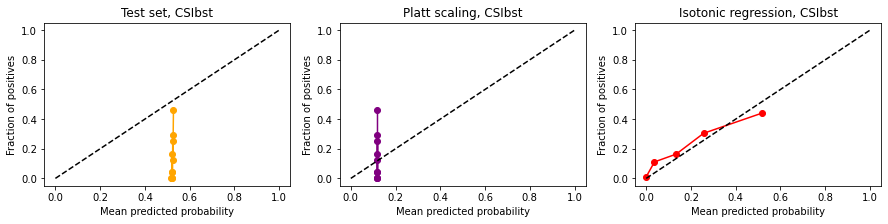

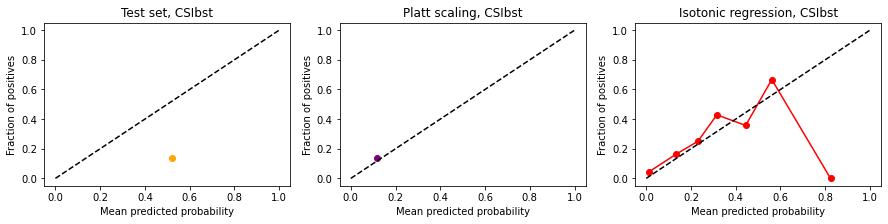

In [13]:
# evaluate calibration on test set 
for binning in ['quantile','uniform']:
    print(binning)
    prob_true, prob_pred = calibration_curve(y_test, ptest, n_bins=10, strategy=binning)
    prob_true_platt, prob_pred_platt = calibration_curve(y_test, p_platt, n_bins=10, strategy=binning)
    prob_true_iso, prob_pred_iso = calibration_curve(y_test, p_iso, n_bins=10, strategy=binning)

    fig,ax=plt.subplots(1,3,figsize=(15,3))
    ax[0].plot(prob_pred, prob_true, color='orange',marker='o')
    ax[0].plot([0,1],[0,1],'k--')
    ax[0].set_xlabel('Mean predicted probability')
    ax[0].set_ylabel('Fraction of positives')
    ax[0].set_title('Test set, {}'.format(model_name))

    ax[1].plot(prob_pred_platt, prob_true_platt, color='purple',marker='o')
    ax[1].plot([0,1],[0,1],'k--')
    ax[1].set_xlabel('Mean predicted probability')
    ax[1].set_ylabel('Fraction of positives')
    ax[1].set_title('Platt scaling, {}'.format(model_name))

    ax[2].plot(prob_pred_iso, prob_true_iso, color='red',marker='o')
    ax[2].plot([0,1],[0,1],'k--')
    ax[2].set_xlabel('Mean predicted probability')
    ax[2].set_ylabel('Fraction of positives')
    ax[2].set_title('Isotonic regression, {}'.format(model_name))

Text(0.5, 0, 'CSIbst ptest')

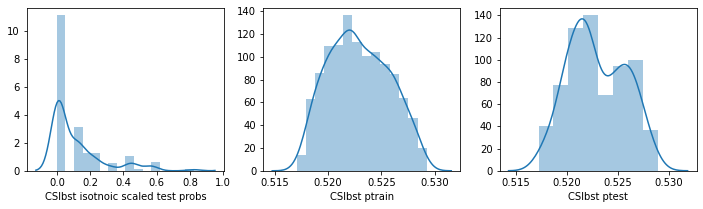

In [14]:
fig,ax = plt.subplots(1,3,figsize=(12,3))
sns.distplot(p_iso, ax=ax[0])
ax[0].set_xlabel('{} isotnoic scaled test probs'.format(model_name))

sns.distplot(ptrain, ax=ax[1])
ax[1].set_xlabel('{} ptrain'.format(model_name))

sns.distplot(ptest, ax=ax[2])
ax[2].set_xlabel('{} ptest'.format(model_name))

